# Planning

## Challenge
This is an open-ended challenge to find something interesting and useful (with a business case!) from a dataset of New York City's restaurant health inspections. The inspections are performed by the Department of Health and Mental Hygiene (DOHMH). Some suggestions include identifying trends or actionable insights, or providing recommendations. The audience could be restaurant customers, inspectors, or restauranteurs.
I came up with some questions I was interested in answering:
1. What factors contribute to inspection failures?
2. Is there any evidence of geographic bias in inspections?
3. Is there any evidence of cuisine bias in inspections?
4. Is there any evidence of inspection timing affecting results?

## Approach
I cleaned, plotted, and examined the data. Documentation describing the inspection process suggested two possible outcome variables to look into: 1) initial inspection failure and 2) closure after reinspection. I wanted to investigate both, but started with initial inspection failure.
I investigated both logistic regression and random forest classification models. I chose to focus on the logistic regression results because I wanted to be able to interpret the coefficients and odds ratios. I tuned hyperparameters and evaluated the model using AUC ROC, because it is a good overall summary of model performance, considering all cells of the confusion matrix. A logistic regression model with L2 (ridge) regression and a penalty of 0.1 classifies initial inspection failures with an AUC of 0.932.

## Results

### 1. What factors contribute to inspection failures?

Looking at the odds ratios for each of the features in the logistic regression model, here are some of the most important factors affecting initial inspection failure.

- Features associated with lower odds of passing initial inspection:
    - Violation codes related to the presence of mice, rats, cockroaches, or flies
    - Violation codes related to lack of washing facilities, lack of food safety plan, improper food storage temperature, and lack of a required certificate
    - The borough Queens
    - Many kinds of cuisine, including Bangladeshi, Indian, Moroccan, Asian, Malaysian, Spanish, African, Turkish, Latin, Chinese, Mediterranean, Hawaiian, Egyptian, Thai, etc.
    - The number of violations cited

- Features associated with higher odds of passing initial inspection:
    - Violation codes with lower stakes issues, such as violation of a recently-introduced ban on styrofoam, improper lighting or ventilation, or reuse of single use items
    - The borough Staten Island
    - Many kinds of cuisine including ice cream, hot dogs, donuts, soups/sandwiches, hamburgers, Continental, cafe/coffee/tea shops, juices/smoothies, Ethiopian, steak, sandwiches, bakeries, bagel/pretzel shops, etc. Many of these seem to be shops that would have less food prep and smaller facilities to maintain, so they make sense.
    - Increasing day of the week

### 2. Is there any evidence of geographic bias in inspections?
Yes, there is some evidence for Queens establishments having lower odds of passing the initial inspection and for Staten Island establishments having higher odds of passing. It's difficult to answer this question without a more sophisticated version of logistic regression to use.

### 3. Is there any evidence of cuisine bias in inspections?
Yes, the cuisine types with the lowest odds of passing the initial inspection include many of the "ethnic" cuisines. Other information is needed to determine if this is a cause or an effect.

### 4. Is there any evidence of inspection timing affecting results?
There might be a slight increase in odds of passing the initial inspection for inspections happening later in the week, but it was slight and of unknown significance. There is no evidence of any effect of the time of year (month) on the odds of passing inspection.

## Takeaways
- Restauranteurs in Queens or those running establishments serving at-risk cuisines (e.g. Bangladeshi, Indian, Moroccan, Malaysian, etc.) should be extra vigilant before inspections.
- Restauranteurs should pay special attention to the violations most associated with lower odds of passing the inspection, such as presence of vermin, lack of washing facilities, improper food storage temperature, and lack of required certficiations or food safety plans.
- NYC food inspectors should carefully examine their inspection process to see if it is being affected by bias against certain cuisines.
- Aspiring restauranteurs could open an ice cream, hot dog, donut, soup & sandwich, or coffee & tea shop to start out with lower odds of failing the initial food saftey inspection.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from treeinterpreter import treeinterpreter as ti


sns.set(style="whitegrid", font_scale=1.25)
plt.figure(figsize=(12.8, 9.6), dpi=400)

/Users/leslie/virtualenv/insight-data-challenges/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


<Figure size 5120x3840 with 0 Axes>

<Figure size 5120x3840 with 0 Axes>

In [2]:
data_dir = '~/devel/insight-data-challenges/05-nyc-restaurant-inspections/data'
output_dir = '~/devel/insight-data-challenges/05-nyc-restaurant-inspections/output'

## Read in and clean the user data

In [3]:
inspections = pd.read_csv(
    os.path.join(os.path.expanduser(data_dir), 'DOHMH_New_York_City_Restaurant_Inspection_Results.csv'),
    parse_dates=['INSPECTION DATE', 'GRADE DATE', 'RECORD DATE']
)

display(inspections.info())
display(inspections.head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401215 entries, 0 to 401214
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   CAMIS                  401215 non-null  int64         
 1   DBA                    400833 non-null  object        
 2   BORO                   401215 non-null  object        
 3   BUILDING               400952 non-null  object        
 4   STREET                 401214 non-null  object        
 5   ZIPCODE                395737 non-null  float64       
 6   PHONE                  401198 non-null  object        
 7   CUISINE DESCRIPTION    401215 non-null  object        
 8   INSPECTION DATE        401215 non-null  datetime64[ns]
 9   ACTION                 399879 non-null  object        
 10  VIOLATION CODE         395597 non-null  object        
 11  VIOLATION DESCRIPTION  392214 non-null  object        
 12  CRITICAL FLAG          392214 non-null  obje

None

CAMIS                                    DBA       BORO BUILDING  \
0   50003977                         GORILLA COFFEE   Brooklyn      472   
1   41416621     FIVE GUYS FAMOUS BURGERS AND FRIES     Queens    25455   
2   50070527            BLACK STONE COFFEE ROASTERS  Manhattan      502   
3   50094778                            HAAGEN-DAZS  Manhattan        1   
4   50066646                         TOKOYO EXPRESS     Queens     7057   
5   41699414                                 SBARRO     Queens     9015   
6   41370589                           DELI & GRILL   Brooklyn     5001   
7   50000891                              LA MESITA   Brooklyn     1513   
8   41034980                                    ISE  Manhattan       63   
9   50091736                         DOMINO'S PIZZA      Bronx      946   
10  41576311                           PICCOLO CAFE  Manhattan      238   
11  50061387    FAMILY ALTAGRACIA CARIBBEAN CUISINE   Brooklyn     5601   
12  41186059                             BAGELBERRY     Queens     3113   
13  41716806                          CHEF'S GARDEN     Queens     8009   
14  50066276  EL SABOR AZOGUENO BAKERY & RESTAURANT     Queens    10119   

                       STREET  ZIPCODE       PHONE  \
0                   BERGEN ST  11217.0  3479873766   
1   HORACE HARDING EXPRESSWAY  11362.0  7186312100   
2                   HUDSON ST  10014.0  2129896131   
3                    PENN PLZ  10119.0  9176051331   
4                PARSONS BLVD  11365.0  3474750510   
5            QUEENS BOULEVARD  11373.0  7182710681   
6                    4 AVENUE  11220.0  7187650080   
7                  MYRTLE AVE  11237.0  7183668700   
8               COOPER SQUARE  10003.0  2122284152   
9               SOUTHERN BLVD  10459.0  2035360660   
10             MADISON AVENUE  10016.0  2124474399   
11               CLARENDON RD  11203.0  9177212661   
12                  30 AVENUE  11102.0  7189321425   
13                 164 STREET  11432.0  7183800956   
14                   37TH AVE  11368.0  9178326801   

                                  CUISINE DESCRIPTION INSPECTION DATE  \
0                                     Café/Coffee/Tea      2018-01-10   
1                                          Hamburgers      2017-04-17   
2                                            American      2018-01-12   
3                                            American      2019-07-11   
4                                            Japanese      2017-10-13   
5                                            American      2018-05-15   
6   Latin (Cuban, Dominican, Puerto Rican, South &...      2018-10-30   
7                                             Mexican      2017-11-16   
8                                            Japanese      2018-08-09   
9                                               Pizza      2019-07-15   
10                                            Italian      2019-11-15   
11                                          Caribbean      2019-01-18   
12                                           American      2019-11-04   
13                                            Chinese      2019-06-27   
14  Latin (Cuban, Dominican, Puerto Rican, South &...      2018-04-03   

                                               ACTION  ... RECORD DATE  \
0     Violations were cited in the following area(s).  ...  2020-03-07   
1     Violations were cited in the following area(s).  ...  2020-03-07   
2     Violations were cited in the following area(s).  ...  2020-03-07   
3     Violations were cited in the following area(s).  ...  2020-03-07   
4     Violations were cited in the following area(s).  ...  2020-03-07   
5     Violations were cited in the following area(s).  ...  2020-03-07   
6     Violations were cited in the following area(s).  ...  2020-03-07   
7     Violations were cited in the following area(s).  ...  2020-03-07   
8     Violations were cited in the following area(s).  ...  2020-03-07   
9     Violations were cited in t

### Fix data types

Find the categorical variables

In [4]:
# Are there any that look categorical based on number of unique values?
values_per_variable = inspections.apply('nunique', 0)
variable_dtypes = inspections.dtypes.apply(lambda x: x.name)
variable_info = pd.DataFrame({'n_categories': values_per_variable,
                              'dtype': variable_dtypes,
                              'variable': values_per_variable.index}).reset_index(drop=True)
display(variable_info)

# Convert columns to categorical
cat_threshold = 110  # If n unique values is below this, it's probably categorical
known_cat_cols = [
    'ACTION', 'BORO', 'GRADE', 'INSPECTION TYPE', 'CRITICAL FLAG', 'CUISINE DESCRIPTION',
    'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'Community Board', 'Council District'
]

variable_info['to_category'] = (variable_info['n_categories'] < cat_threshold)\
                               & (~variable_info['dtype'].isin(('datetime64[ns]', )))
display(variable_info)
# Are there any known categorical variables missing? Or vice versa?
set(variable_info['variable'].loc[variable_info['to_category']].to_list()) - set(known_cat_cols)
set(known_cat_cols) - set(variable_info['variable'].loc[variable_info['to_category']].to_list())

for v in variable_info['variable'].loc[variable_info['to_category']]:
    inspections[v] = inspections[v].astype('category')

display(inspections.info())
variable_info['dtype'] = inspections.dtypes.apply(lambda x: x.name).to_numpy()

n_categories           dtype               variable
0          27308           int64                  CAMIS
1          21611          object                    DBA
2              6          object                   BORO
3           7307          object               BUILDING
4           3239          object                 STREET
5            226         float64                ZIPCODE
6          25552          object                  PHONE
7             84          object    CUISINE DESCRIPTION
8           1341  datetime64[ns]        INSPECTION DATE
9              5          object                 ACTION
10           104          object         VIOLATION CODE
11            89          object  VIOLATION DESCRIPTION
12             2          object          CRITICAL FLAG
13           136         float64                  SCORE
14             7          object                  GRADE
15          1272  datetime64[ns]             GRADE DATE
16             1  datetime64[ns]            RECORD DATE
17            31          object        INSPECTION TYPE
18         22694         float64               Latitude
19         22694         float64              Longitude
20            69         float64        Community Board
21            51         float64       Council District
22          1184         float64           Census Tract
23         19733         float64                    BIN
24         19435         float64                    BBL
25           193          object                    NTA

n_categories           dtype               variable  to_category
0          27308           int64                  CAMIS        False
1          21611          object                    DBA        False
2              6          object                   BORO         True
3           7307          object               BUILDING        False
4           3239          object                 STREET        False
5            226         float64                ZIPCODE        False
6          25552          object                  PHONE        False
7             84          object    CUISINE DESCRIPTION         True
8           1341  datetime64[ns]        INSPECTION DATE        False
9              5          object                 ACTION         True
10           104          object         VIOLATION CODE         True
11            89          object  VIOLATION DESCRIPTION         True
12             2          object          CRITICAL FLAG         True
13           136         float64                  SCORE        False
14             7          object                  GRADE         True
15          1272  datetime64[ns]             GRADE DATE        False
16             1  datetime64[ns]            RECORD DATE        False
17            31          object        INSPECTION TYPE         True
18         22694         float64               Latitude        False
19         22694         float64              Longitude        False
20            69         float64        Community Board         True
21            51         float64       Council District         True
22          1184         float64           Census Tract        False
23         19733         float64                    BIN        False
24         19435         float64                    BBL        False
25           193          object                    NTA        False

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401215 entries, 0 to 401214
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   CAMIS                  401215 non-null  int64         
 1   DBA                    400833 non-null  object        
 2   BORO                   401215 non-null  category      
 3   BUILDING               400952 non-null  object        
 4   STREET                 401214 non-null  object        
 5   ZIPCODE                395737 non-null  float64       
 6   PHONE                  401198 non-null  object        
 7   CUISINE DESCRIPTION    401215 non-null  category      
 8   INSPECTION DATE        401215 non-null  datetime64[ns]
 9   ACTION                 399879 non-null  category      
 10  VIOLATION CODE         395597 non-null  category      
 11  VIOLATION DESCRIPTION  392214 non-null  category      
 12  CRITICAL FLAG          392214 non-null  cate

None

### Convert zipcode to an int

In [5]:
display(inspections['ZIPCODE'].describe())
display(inspections['ZIPCODE'].isna().sum())  # 5500 NaN values, which is why it's not an int. Leave it for now.

count    395737.000000
mean      10678.272221
std         596.579121
min       10000.000000
25%       10022.000000
50%       10468.000000
75%       11229.000000
max       12345.000000
Name: ZIPCODE, dtype: float64

5478

### Fix missing value codes

In [6]:
inspections['BORO'] = inspections['BORO'].replace('0', np.NaN)

for v in inspections.select_dtypes(include='category').columns:
    print('_' * 20)
    print(v)
    display(inspections[v].value_counts(dropna=False))

new_establishment_inspection_date = datetime(1900, 1, 1)
inspections['INSPECTION DATE'] = inspections['INSPECTION DATE'].replace(new_establishment_inspection_date, pd.NaT)

for v in inspections.select_dtypes(include='datetime').columns:
    print('_' * 20)
    print(v)
    display(inspections[v].value_counts(dropna=False))

display(inspections.select_dtypes(include='number').describe())

variable_info['n_missing'] = inspections.apply(lambda x: x.isna().sum()).to_numpy()

____________________
BORO


Manhattan        158069
Brooklyn         101968
Queens            91487
Bronx             36178
Staten Island     13435
NaN                  78
Name: BORO, dtype: int64

____________________
CUISINE DESCRIPTION


American                                                            83714
Chinese                                                             42261
Café/Coffee/Tea                                                     19734
Latin (Cuban, Dominican, Puerto Rican, South & Central American)    17661
Pizza                                                               17412
                                                                    ...  
Iranian                                                                69
Czech                                                                  43
Nuts/Confectionary                                                     43
Chilean                                                                32
Basque                                                                  7
Name: CUISINE DESCRIPTION, Length: 84, dtype: int64

____________________
ACTION


Violations were cited in the following area(s).                                                                                        375088
Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.     15144
Establishment re-opened by DOHMH                                                                                                         4387
No violations were recorded at the time of this inspection.                                                                              4139
NaN                                                                                                                                      1336
Establishment re-closed by DOHMH                                                                                                         1121
Name: ACTION, dtype: int64

____________________
VIOLATION CODE


10F     57279
08A     44548
04L     29871
06D     27487
06C     24358
        ...  
19A1        1
02J         1
04I         1
17A3        1
15G7        1
Name: VIOLATION CODE, Length: 105, dtype: int64

____________________
VIOLATION DESCRIPTION


Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.    57279
Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.                                                                                                                                                 44548
Evidence of mice or live mice present in facility's food and/or non-food areas.                                                                                                                                                                                                    29871
Food contact surface not properly washed, rinsed and sanitized after each use and following any activity when contamination may have occurred.               

____________________
CRITICAL FLAG


Y      219056
N      173158
NaN      9001
Name: CRITICAL FLAG, dtype: int64

____________________
GRADE


NaN    197976
A      160033
B       25186
C        9380
Z        3311
N        2664
P        2659
G           6
Name: GRADE, dtype: int64

____________________
INSPECTION TYPE


Cycle Inspection / Initial Inspection                          234621
Cycle Inspection / Re-inspection                                96271
Pre-permit (Operational) / Initial Inspection                   28601
Pre-permit (Operational) / Re-inspection                        12305
Administrative Miscellaneous / Initial Inspection                7379
Cycle Inspection / Reopening Inspection                          4436
Pre-permit (Non-operational) / Initial Inspection                3489
Smoke-Free Air Act / Initial Inspection                          2021
Administrative Miscellaneous / Re-inspection                     1999
Trans Fat / Initial Inspection                                   1543
NaN                                                              1336
Pre-permit (Operational) / Compliance Inspection                 1298
Calorie Posting / Initial Inspection                             1232
Inter-Agency Task Force / Initial Inspection                     1082
Pre-permit (Operatio

____________________
Community Board


105.0    32469
103.0    21203
102.0    19342
104.0    16302
407.0    14029
         ...  
355.0       79
227.0       62
226.0       12
595.0       11
482.0        5
Name: Community Board, Length: 70, dtype: int64

____________________
Council District


3.0     35338
1.0     31399
4.0     30789
2.0     21223
33.0    12457
20.0    11331
34.0    11197
38.0    10836
26.0    10739
39.0     9912
35.0     8856
5.0      8593
22.0     8564
25.0     7697
21.0     7554
43.0     7461
6.0      6879
8.0      6815
7.0      6497
10.0     6126
19.0     5958
29.0     5893
NaN      5882
47.0     5760
28.0     5598
49.0     5409
40.0     5297
32.0     5171
37.0     5154
36.0     5032
15.0     4939
48.0     4907
9.0      4902
13.0     4820
11.0     4812
24.0     4739
30.0     4674
17.0     4240
27.0     4099
50.0     4035
14.0     3826
51.0     3791
23.0     3669
45.0     3629
41.0     3628
46.0     3451
12.0     3407
18.0     3275
44.0     3111
16.0     2844
42.0     2802
31.0     2198
Name: Council District, dtype: int64

____________________
INSPECTION DATE


NaT           1336
2019-11-07     867
2019-10-30     846
2019-03-28     841
2020-01-22     841
              ... 
2016-02-05       1
2017-12-17       1
2016-09-11       1
2016-07-16       1
2015-10-03       1
Name: INSPECTION DATE, Length: 1341, dtype: int64

____________________
GRADE DATE


NaT           200632
2019-06-13       501
2019-06-05       494
2019-06-11       480
2019-06-12       474
               ...  
2017-05-08         1
2016-04-10         1
2015-09-24         1
2016-03-03         1
2016-08-06         1
Name: GRADE DATE, Length: 1273, dtype: int64

____________________
RECORD DATE


2020-03-07    401215
Name: RECORD DATE, dtype: int64

CAMIS        ZIPCODE          SCORE       Latitude  \
count  4.012150e+05  395737.000000  384379.000000  400798.000000   
mean   4.619473e+07   10678.272221      20.414005      40.171996   
std    4.397160e+06     596.579121      14.856352       4.728947   
min    3.007544e+07   10000.000000      -1.000000       0.000000   
25%    4.140075e+07   10022.000000      11.000000      40.685816   
50%    5.000831e+07   10468.000000      15.000000      40.732431   
75%    5.005914e+07   11229.000000      26.000000      40.761813   
max    5.010429e+07   12345.000000     164.000000      40.912822   

           Longitude   Census Tract           BIN           BBL  
count  400798.000000  395333.000000  3.935720e+05  4.007980e+05  
mean      -72.932686   28759.335320  2.508252e+06  2.402582e+09  
std         8.584902   30484.225747  1.349706e+06  1.341219e+09  
min       -74.248520     100.000000  1.000000e+06  1.000000e+00  
25%       -73.989243    7800.000000  1.043046e+06  1.010420e+09  
50%       -73.958171   16300.000000  3.007552e+06  3.001870e+09  
75%       -73.899383   40300.000000  4.001569e+06  4.001620e+09  
max         0.000000  162100.000000  5.799501e+06  5.270001e+09

### Make a map from violation code to violation description

In [7]:
# Check if there's more than one description per violation code, to see if it will work to select the first one
display(
    inspections[['VIOLATION CODE', 'VIOLATION DESCRIPTION']].groupby(
        'VIOLATION CODE').aggregate('nunique')['VIOLATION DESCRIPTION'].value_counts()
)

1    89
0    15
Name: VIOLATION DESCRIPTION, dtype: int64

There are 15 violation codes without any matching description.

In [8]:
inspections['VIOLATION CODE'].nunique()
violation_descriptions = inspections[['VIOLATION CODE', 'VIOLATION DESCRIPTION']].groupby(
    'VIOLATION CODE').aggregate('first')

with pd.option_context('display.max_rows', 200):
    display(violation_descriptions)

VIOLATION DESCRIPTION
VIOLATION CODE                                                   
02A              Food not cooked to required minimum temperature.
02B                    Hot food item not held at or above 140º F.
02C             Hot food item that has been cooked and refrige...
02D             Precooked potentially hazardous food from comm...
02E             Whole frozen poultry or poultry breasts, other...
02F             Meat, fish or molluscan shellfish served raw o...
02G             Cold food item held above 41º F (smoked fish a...
02H             Food not cooled by an approved method whereby ...
02I             Food prepared from ingredients at ambient temp...
02J             Reduced oxygen packaged (ROP) foods not cooled...
03A             Food from unapproved or unknown source or home...
03B             Shellfish not from approved source, improperly...
03C             Eggs found dirty/cracked; liquid, frozen or po...
03D             Canned food product observed swollen, leaking ...
03E             Potable water supply inadequate. Water or ice ...
03F                   Unpasteurized milk or milk product present.
03G                Raw food not properly washed prior to serving.
04A             Food Protection Certificate not held by superv...
04B             Food worker prepares food or handles utensil w...
04C             Food worker does not use proper utensil to eli...
04D             Food worker does not wash hands thoroughly aft...
04E             Toxic chemical improperly labeled, stored or u...
04F             Food, food preparation area, food storage area...
04G             Unprotected potentially hazardous food re-served.
04H             Raw, cooked or prepared food is adulterated, c...
04I                                   Unprotected food re-served.
04J             Appropriately scaled metal stem-type thermomet...
04K             Evidence of rats or live rats present in facil...
04L             Evidence of mice or live mice present in facil...
04M             Live roaches present in facility's food and/or...
04N             Filth flies or food/refuse/sewage-associated (...
04O             Live animals other than fish in tank or servic...
05A                Sewage disposal system improper or unapproved.
05B             Harmful, noxious gas or vapor detected. CO ~1 ...
05C             Food contact surface improperly constructed or...
05D             Hand washing facility not provided in or near ...
05E             Toilet facility not provided for employees or ...
05F             Insufficient or no refrigerated or hot holding...
05H             No facilities available to wash, rinse and san...
06A             Personal cleanliness inadequate. Outer garment...
06B             Tobacco use, eating, or drinking from open con...
06C             Food not protected from potential source of co...
06D             Food contact surface not properly washed, rins...
06E             Sanitized equipment or utensil, including in-u...
06F             Wiping cloths soiled or not stored in sanitizi...
06G             HACCP plan not approved or approved HACCP plan...
06H             Records and logs not maintained to demonstrate...
06I               Food not labeled in accordance with HACCP plan.
07A             Duties of an officer of the Department interfe...
08A             Facility not vermin proof. Harborage or condit...
08B             Covered garbage receptacle not provided or ina...
08C             Pesticide use not in accordance with label or ...
09A             Canned food product observed dented and not se...
09B                                  Thawing procedures improper.
09C                 Food contact surface not properly maintained.
10A             Toilet facility not maintained and provided wi...
10B             Plumbing not properly installed or maintained;...
10C             Lighting inadequate; permanent lighting not pr...
10D             Mechanical or natural ventilation system not p...
10E             Ac

## Add some derived variables

### Use documentation instructions to label gradeable/ungradeable inspections

In [9]:
gradeable_inspection_types = (
    'Cycle Inspection / Initial Inspection',
    'Cycle Inspection / Re-Inspection',
    'Pre-Permit (Operational) / Initial Inspection',
    'Pre-Permit (Operational)/Re-Inspection',
)
gradeable_actions = (
    'Violations were cited in the following area(s).',
    'No violations were recorded at the time of this inspection.',
    'Establishment Closed by DOHMH.',
)
gradeable_inspection_date_min = datetime(2010, 7, 27)

inspections['INSPECTION TYPE'].isin(gradeable_inspection_types).sum()
inspections['ACTION'].isin(gradeable_actions).sum()
np.sum(inspections['INSPECTION DATE'] >= gradeable_inspection_date_min)

inspections['is_gradeable'] = ((inspections['INSPECTION TYPE'].isin(gradeable_inspection_types))
                               & (inspections['ACTION'].isin(gradeable_actions))
                               & (inspections['INSPECTION DATE'] >= gradeable_inspection_date_min)
                               )
display(inspections['is_gradeable'].value_counts(dropna=False))

True     225616
False    175599
Name: is_gradeable, dtype: int64

### Add variables for what kind of inspection it was

In [10]:
inspections['INSPECTION TYPE'].value_counts()
inspections['is_cycle_inspection'] = inspections['INSPECTION TYPE'].str.contains('Cycle')
inspections['is_opening_inspection'] = inspections['INSPECTION TYPE'].str.contains(
    'Pre-permit (Operational)', regex=False)
inspections['is_initial_inspection'] = inspections['INSPECTION TYPE'].str.contains('Initial')
inspections['is_reinspection'] = inspections['INSPECTION TYPE'].str.contains('Re-inspection')
inspections['is_compliance_inspection'] = inspections['INSPECTION TYPE'].str.contains('Compliance')

### Add variables for date components

In [11]:
inspections['inspection_year'] = inspections['INSPECTION DATE'].dt.year.astype('category')
inspections['inspection_month'] = inspections['INSPECTION DATE'].dt.month.astype('category')
inspections['inspection_day'] = inspections['INSPECTION DATE'].dt.day
inspections['inspection_dayofyear'] = inspections['INSPECTION DATE'].dt.dayofyear
inspections['inspection_dayofweek'] = inspections['INSPECTION DATE'].dt.dayofweek.astype('category')
inspections['inspection_isweekday'] = inspections['inspection_dayofweek'].isin(range(5))
inspections['inspection_week'] = inspections['INSPECTION DATE'].dt.week.astype('category')
display(inspections.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401215 entries, 0 to 401214
Data columns (total 39 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   CAMIS                     401215 non-null  int64         
 1   DBA                       400833 non-null  object        
 2   BORO                      401137 non-null  category      
 3   BUILDING                  400952 non-null  object        
 4   STREET                    401214 non-null  object        
 5   ZIPCODE                   395737 non-null  float64       
 6   PHONE                     401198 non-null  object        
 7   CUISINE DESCRIPTION       401215 non-null  category      
 8   INSPECTION DATE           399879 non-null  datetime64[ns]
 9   ACTION                    399879 non-null  category      
 10  VIOLATION CODE            395597 non-null  category      
 11  VIOLATION DESCRIPTION     392214 non-null  category      
 12  CR

None

## Plot everything

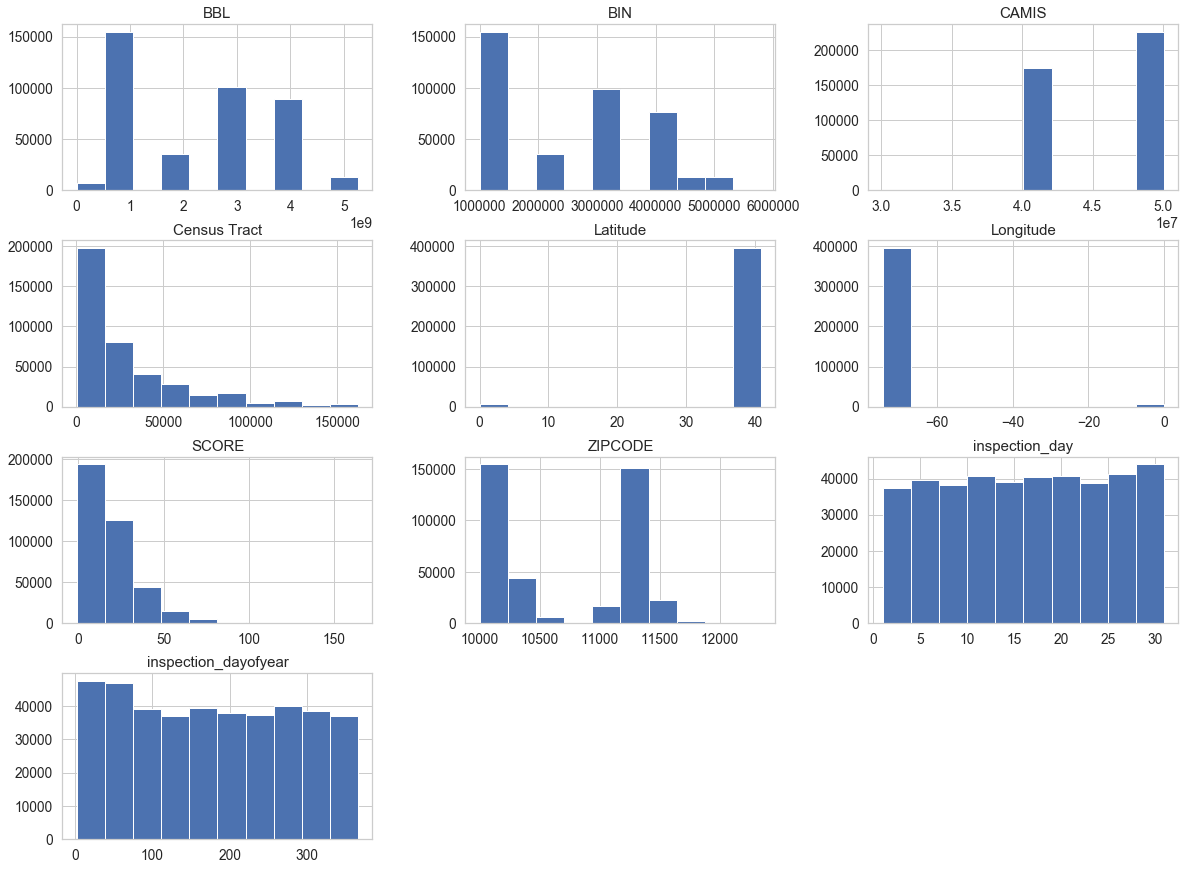

In [12]:
# Try the Pandas built in histogram function, even though it's mediocre
inspections.select_dtypes(exclude='bool').hist(figsize=(20, 15))
plt.show()
# And it fails on boolean columns!

### Histograms of the numeric variables

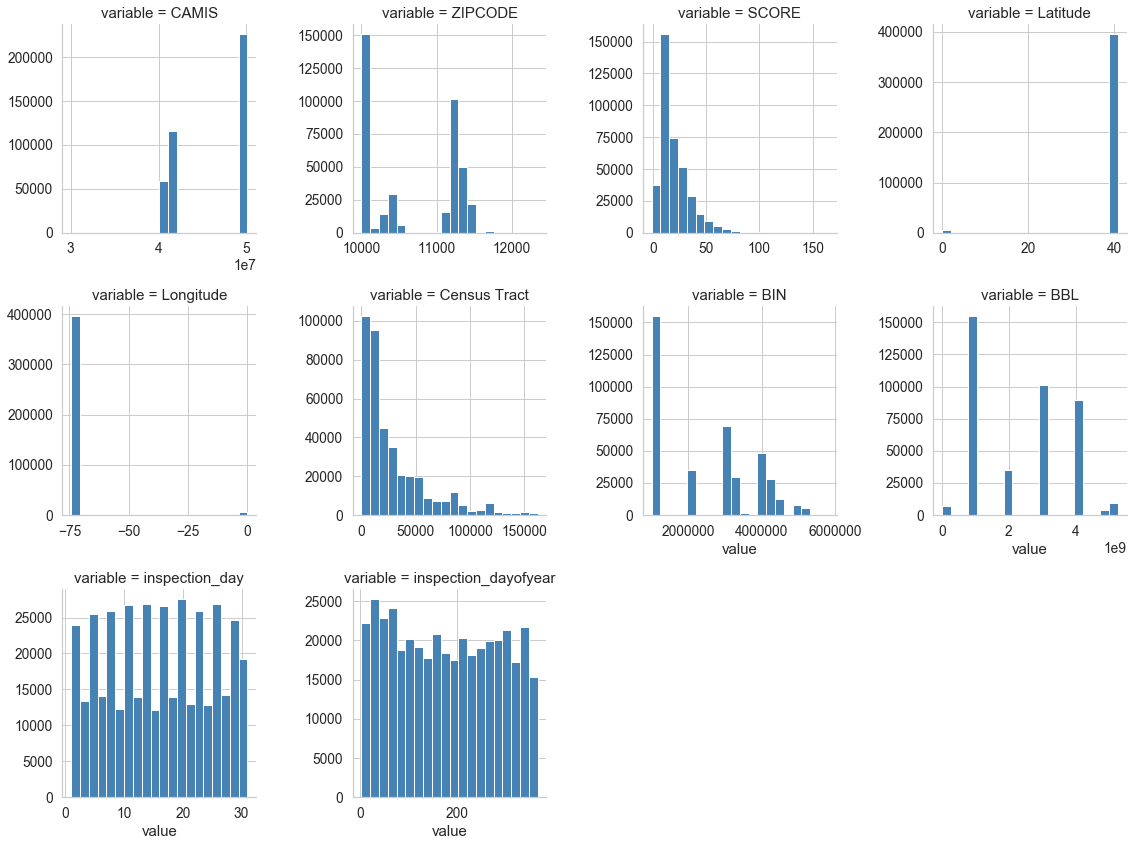

In [13]:
g = sns.FacetGrid(
    inspections.select_dtypes(include='number').melt(), col='variable', col_wrap=4,
    sharex=False, sharey=False, height=4
)
g.map(plt.hist, 'value', color='steelblue', bins=20)
plt.show()

### Barplots of the categorical & boolean variables

Individual plots for variables with too many categories

In [14]:
cat_col_n_values = inspections.select_dtypes(include='category').apply('nunique', 0)
many_values_cat_vars = cat_col_n_values.loc[cat_col_n_values > 20].index
other_cat_vars = cat_col_n_values.loc[cat_col_n_values <= 20].index

# for v in many_values_cat_vars:
#     g = sns.countplot(data=inspections, x=v)
#     g.set_xticklabels(g.get_xticklabels(), rotation=60, horizontalalignment='right')
#     plt.tight_layout()
#     plt.show()

# The best is really just a sorted table of value counts.
for v in many_values_cat_vars:
    print('_' * 20)
    print(v)
    with pd.option_context('display.max_rows', cat_threshold):
        display(inspections[v].value_counts(dropna=False))

____________________
CUISINE DESCRIPTION


American                                                            83714
Chinese                                                             42261
Café/Coffee/Tea                                                     19734
Latin (Cuban, Dominican, Puerto Rican, South & Central American)    17661
Pizza                                                               17412
Mexican                                                             16654
Italian                                                             16206
Japanese                                                            14566
Caribbean                                                           14447
Spanish                                                             12548
Bakery                                                              12493
Pizza/Italian                                                        8328
Chicken                                                              7606
Indian                                

____________________
VIOLATION CODE


10F     57279
08A     44548
04L     29871
06D     27487
06C     24358
10B     23483
02G     23047
04N     21081
02B     20519
04M      8870
04H      8736
06E      7519
04A      7156
06F      6913
09C      6680
06A      6592
08C      6508
10H      6486
02H      6291
NaN      5618
09B      4394
10I      4140
05D      3831
06B      2756
04K      2756
20F      2745
04C      2670
10E      2544
10J      1871
04J      1697
10D      1623
16B      1420
15F6     1366
20D      1291
22C      1165
09A      1155
05H      1119
10A      1008
22G       825
05F       805
03A       804
22A       799
22F       608
05C       542
02I       515
16D       506
20A       503
02C       480
16E       470
16C       452
08B       427
10C       395
04E       365
15L       352
02A       309
04O       272
04F       262
03B       225
05A       209
05E       209
04D       193
15F7      161
06G       159
20E       155
15E2      147
22E       146
05B       120
18G       112
16A       108
15F1      108
18D        97
15I   

____________________
VIOLATION DESCRIPTION


Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.                                                                                             57279
Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.                                                                                                                                                                                                                                          44548
Evidence of mice or live mice present in facility's food and/or non-food areas.                                                                                                                                                                                     

____________________
INSPECTION TYPE


Cycle Inspection / Initial Inspection                          234621
Cycle Inspection / Re-inspection                                96271
Pre-permit (Operational) / Initial Inspection                   28601
Pre-permit (Operational) / Re-inspection                        12305
Administrative Miscellaneous / Initial Inspection                7379
Cycle Inspection / Reopening Inspection                          4436
Pre-permit (Non-operational) / Initial Inspection                3489
Smoke-Free Air Act / Initial Inspection                          2021
Administrative Miscellaneous / Re-inspection                     1999
Trans Fat / Initial Inspection                                   1543
NaN                                                              1336
Pre-permit (Operational) / Compliance Inspection                 1298
Calorie Posting / Initial Inspection                             1232
Inter-Agency Task Force / Initial Inspection                     1082
Pre-permit (Operatio

____________________
Community Board


105.0    32469
103.0    21203
102.0    19342
104.0    16302
407.0    14029
106.0    13583
301.0    12576
108.0    12283
101.0    11576
401.0    11330
302.0     9694
307.0     8753
107.0     8510
306.0     8474
403.0     7955
402.0     7738
404.0     7272
112.0     7064
311.0     6565
412.0     6499
405.0     6451
310.0     6429
501.0     5980
NaN       5894
315.0     5360
304.0     5123
303.0     5068
314.0     4963
409.0     4843
111.0     4696
308.0     4670
410.0     4385
312.0     4277
411.0     4226
318.0     4179
413.0     4139
406.0     4131
109.0     4121
110.0     4030
502.0     3974
317.0     3927
408.0     3897
204.0     3866
210.0     3827
305.0     3821
212.0     3559
209.0     3356
309.0     3340
201.0     3291
503.0     3270
207.0     3094
205.0     2961
206.0     2943
208.0     2826
211.0     2793
313.0     2345
316.0     1655
414.0     1628
202.0     1511
203.0     1247
483.0     1057
480.0      354
481.0      137
228.0      105
164.0       80
355.0       79
227.0     

____________________
Council District


3.0     35338
1.0     31399
4.0     30789
2.0     21223
33.0    12457
20.0    11331
34.0    11197
38.0    10836
26.0    10739
39.0     9912
35.0     8856
5.0      8593
22.0     8564
25.0     7697
21.0     7554
43.0     7461
6.0      6879
8.0      6815
7.0      6497
10.0     6126
19.0     5958
29.0     5893
NaN      5882
47.0     5760
28.0     5598
49.0     5409
40.0     5297
32.0     5171
37.0     5154
36.0     5032
15.0     4939
48.0     4907
9.0      4902
13.0     4820
11.0     4812
24.0     4739
30.0     4674
17.0     4240
27.0     4099
50.0     4035
14.0     3826
51.0     3791
23.0     3669
45.0     3629
41.0     3628
46.0     3451
12.0     3407
18.0     3275
44.0     3111
16.0     2844
42.0     2802
31.0     2198
Name: Council District, dtype: int64

____________________
inspection_week


9.0     10171
7.0     10097
6.0      9937
10.0     9742
5.0      9239
3.0      9092
43.0     8883
8.0      8847
2.0      8826
49.0     8633
39.0     8508
4.0      8358
24.0     8316
44.0     8251
51.0     8245
13.0     8181
38.0     8076
23.0     8066
50.0     8013
30.0     7834
37.0     7826
14.0     7820
25.0     7742
32.0     7740
21.0     7704
31.0     7665
40.0     7653
26.0     7594
35.0     7523
20.0     7491
16.0     7429
42.0     7426
12.0     7409
29.0     7397
18.0     7394
34.0     7304
19.0     7287
33.0     7245
11.0     7169
41.0     7084
46.0     6952
17.0     6900
28.0     6877
15.0     6858
48.0     6774
47.0     6747
45.0     6681
22.0     5845
36.0     5750
52.0     5321
27.0     5024
1.0      4933
NaN      1336
Name: inspection_week, dtype: int64

A facet grid for those with fewer categories

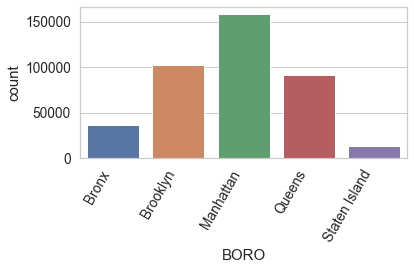

<ipython-input-15-7268e5fae820>:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


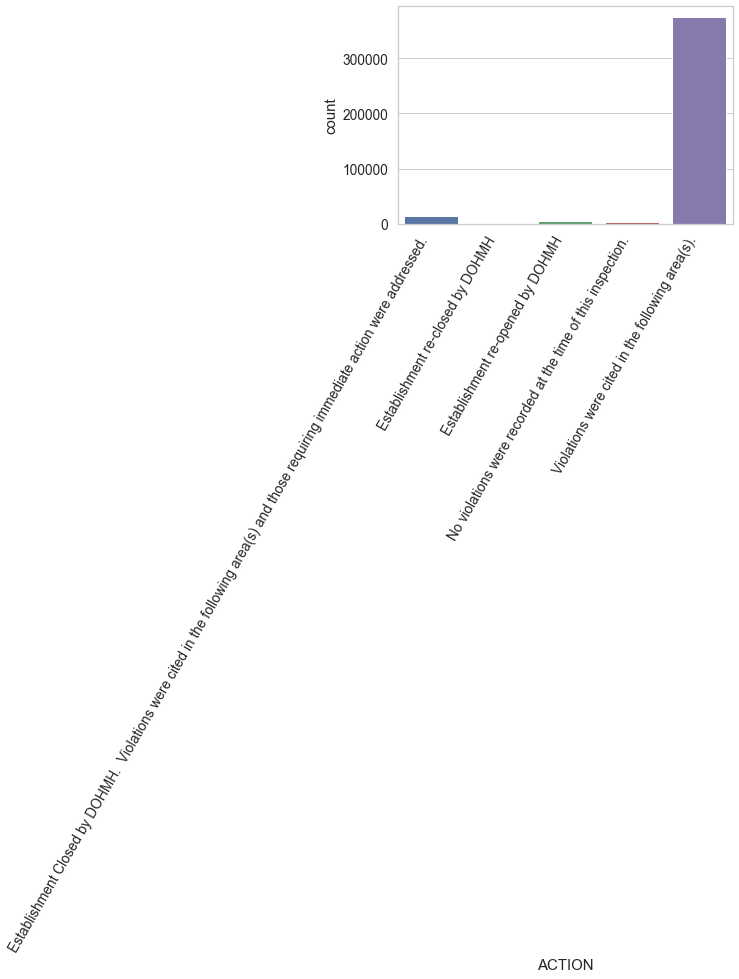

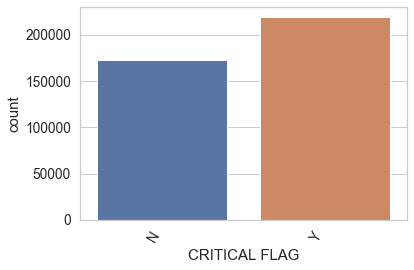

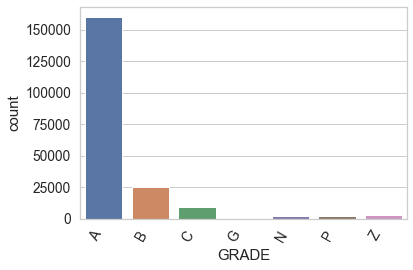

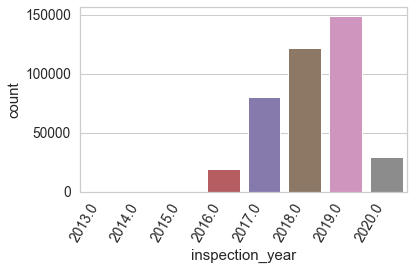

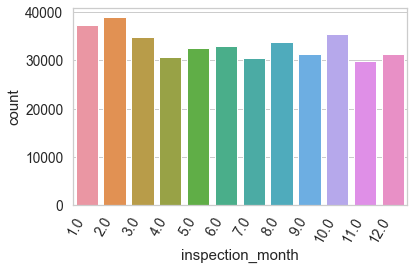

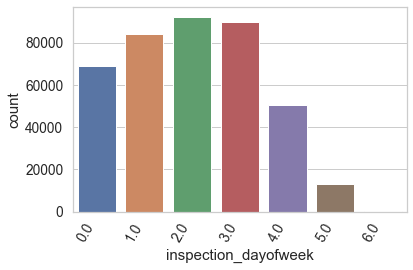

In [15]:
# tmp = inspections[other_cat_vars].melt()
# tmp['value_trunc'] = tmp['value'].str.slice(stop=25)
# g = sns.catplot(
#     data=tmp, col='variable', col_wrap=3,
#     x='value_trunc', kind='count',
#     facet_kws={'sharex': False, 'sharey': False},
#     margin_titles=False
# )
# for ax in g.axes.flat:
#     for label in ax.get_xticklabels():
#         label.set_rotation(70)
# plt.show()
# I can't get the sharex/sharey arguments to work properly. God do I miss ggplot!

for v in other_cat_vars:
    g = sns.countplot(data=inspections, x=v)
    g.set_xticklabels(g.get_xticklabels(), rotation=60, horizontalalignment='right')
    plt.tight_layout()
    plt.show()

### Histograms of the datetime variables

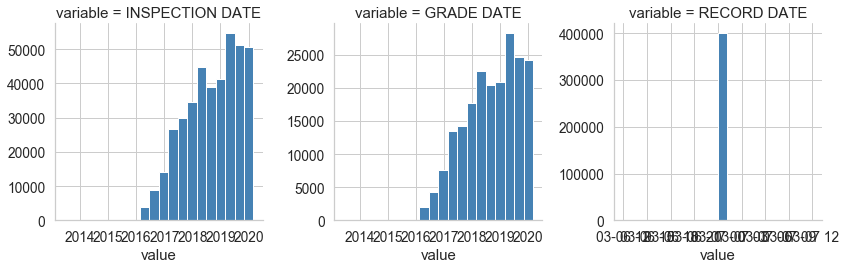

In [16]:
g = sns.FacetGrid(
    inspections.select_dtypes(include='datetime').melt(), col='variable', col_wrap=3,
    sharex=False, sharey=False, height=4
)
g.map(plt.hist, 'value', color='steelblue', bins=20)
plt.show()

### Head and tail of the object variables

In [17]:
for v in inspections.select_dtypes(include='object').columns:
    print('_' * 20)
    print(v)
    display(inspections[v].head(15))
    display(inspections[v].tail(15))

____________________
DBA


0                            GORILLA COFFEE
1        FIVE GUYS FAMOUS BURGERS AND FRIES
2               BLACK STONE COFFEE ROASTERS
3                               HAAGEN-DAZS
4                            TOKOYO EXPRESS
5                                    SBARRO
6                              DELI & GRILL
7                                 LA MESITA
8                                       ISE
9                            DOMINO'S PIZZA
10                             PICCOLO CAFE
11      FAMILY ALTAGRACIA CARIBBEAN CUISINE
12                               BAGELBERRY
13                            CHEF'S GARDEN
14    EL SABOR AZOGUENO BAKERY & RESTAURANT
Name: DBA, dtype: object

401200                                  DALLAS BBQ
401201                                 TEA STATION
401202                                  E SUSHI II
401203                                  SIDO GRILL
401204                                        MURA
401205    CITI FIELD WORLD'S FAIR MARKET/STAND 104
401206                       JOY INDIAN RESTAURANT
401207                             ZUCKER'S BAGELS
401208                                  TRAVEL BAR
401209                           VALENTINO'S PIZZA
401210                             GOLDEN LEAF SKY
401211                              BROADWAY PIZZA
401212                         CROWN FRIED CHICKEN
401213                                  BONDURANTS
401214                                HUDSON BAGEL
Name: DBA, dtype: object

____________________
BUILDING


0       472
1     25455
2       502
3         1
4      7057
5      9015
6      5001
7      1513
8        63
9       946
10      238
11     5601
12     3113
13     8009
14    10119
Name: BUILDING, dtype: object

401200      281
401201     4716
401202     2971
401203     2288
401204      369
401205      000
401206      301
401207      370
401208      520
401209     7147
401210    13617
401211     2709
401212    18903
401213      303
401214       82
Name: BUILDING, dtype: object

____________________
STREET


0                     BERGEN ST
1     HORACE HARDING EXPRESSWAY
2                     HUDSON ST
3                      PENN PLZ
4                  PARSONS BLVD
5              QUEENS BOULEVARD
6                      4 AVENUE
7                    MYRTLE AVE
8                 COOPER SQUARE
9                 SOUTHERN BLVD
10               MADISON AVENUE
11                 CLARENDON RD
12                    30 AVENUE
13                   164 STREET
14                     37TH AVE
Name: STREET, dtype: object

401200               WEST FORDHAM ROAD
401201                       BELL BLVD
401202                       OCEAN AVE
401203         FREDERICK DOUGLASS BLVD
401204                         5TH AVE
401205    126 TH ST & ROOSEVELT AVENUE
401206                 FLATBUSH AVENUE
401207                LEXINGTON AVENUE
401208                        COURT ST
401209               KISSENA BOULEVARD
401210                        41ST AVE
401211                        BROADWAY
401212                LINDEN BOULEVARD
401213                       E 85TH ST
401214                  CHRISTOPHER ST
Name: STREET, dtype: object

____________________
PHONE


0     3479873766
1     7186312100
2     2129896131
3     9176051331
4     3474750510
5     7182710681
6     7187650080
7     7183668700
8     2122284152
9     2035360660
10    2124474399
11    9177212661
12    7189321425
13    7183800956
14    9178326801
Name: PHONE, dtype: object

401200    7182202822
401201    9175489722
401202    7188915888
401203    6463295650
401204    7189651288
401205    7185958100
401206    7182301165
401207    2126611080
401208    3474539295
401209    7185916464
401210    7186616655
401211    2128649298
401212    7189780600
401213    2122491509
401214    7188096990
Name: PHONE, dtype: object

____________________
NTA


0     BK37
1     QN45
2     MN23
3     MN17
4     QN38
5     QN29
6     BK32
7     BK77
8     MN22
9     BX27
10    MN20
11    BK96
12    QN71
13    QN38
14    QN26
Name: NTA, dtype: object

401200    BX30
401201    QN46
401202    BK17
401203    MN11
401204    BK37
401205     NaN
401206    BK64
401207    MN20
401208    BK33
401209    QN38
401210    QN22
401211    MN12
401212    QN08
401213    MN32
401214    MN23
Name: NTA, dtype: object

____________________
is_cycle_inspection


0      True
1      True
2     False
3     False
4     False
5      True
6      True
7      True
8      True
9     False
10     True
11    False
12     True
13     True
14     True
Name: is_cycle_inspection, dtype: object

401200     True
401201     True
401202    False
401203    False
401204     True
401205     True
401206     True
401207     True
401208     True
401209     True
401210     True
401211     True
401212     True
401213     True
401214    False
Name: is_cycle_inspection, dtype: object

____________________
is_opening_inspection


0     False
1     False
2      True
3      True
4      True
5     False
6     False
7     False
8     False
9      True
10    False
11    False
12    False
13    False
14    False
Name: is_opening_inspection, dtype: object

401200    False
401201    False
401202     True
401203     True
401204    False
401205    False
401206    False
401207    False
401208    False
401209    False
401210    False
401211    False
401212    False
401213    False
401214     True
Name: is_opening_inspection, dtype: object

____________________
is_initial_inspection


0      True
1      True
2      True
3      True
4      True
5      True
6      True
7     False
8      True
9     False
10     True
11     True
12     True
13    False
14     True
Name: is_initial_inspection, dtype: object

401200     True
401201     True
401202    False
401203     True
401204    False
401205     True
401206     True
401207    False
401208     True
401209     True
401210     True
401211     True
401212     True
401213     True
401214    False
Name: is_initial_inspection, dtype: object

____________________
is_reinspection


0     False
1     False
2     False
3     False
4     False
5     False
6     False
7      True
8     False
9      True
10    False
11    False
12    False
13     True
14    False
Name: is_reinspection, dtype: object

401200    False
401201    False
401202     True
401203    False
401204     True
401205    False
401206    False
401207     True
401208    False
401209    False
401210    False
401211    False
401212    False
401213    False
401214    False
Name: is_reinspection, dtype: object

____________________
is_compliance_inspection


0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
Name: is_compliance_inspection, dtype: object

401200    False
401201    False
401202    False
401203    False
401204    False
401205    False
401206    False
401207    False
401208    False
401209    False
401210    False
401211    False
401212    False
401213    False
401214    False
Name: is_compliance_inspection, dtype: object

## Filter to most important core inspection types

In [18]:
core_inspections = inspections.loc[(inspections['is_cycle_inspection'] | inspections['is_opening_inspection'])
                                   & (inspections['is_initial_inspection'] | inspections['is_reinspection']), ]
# Make sure it's sorted by ascending inspection date
core_inspections = core_inspections.sort_values('INSPECTION DATE', ascending=True)

## Summary of inspections

### Summary by business

/Users/leslie/virtualenv/insight-data-challenges/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25757 entries, 30075445 to 50103876
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   n_rows                    25757 non-null  int64  
 1   n_inspections             25757 non-null  int64  
 2   avg_inspection_frequency  23445 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 804.9 KB


None

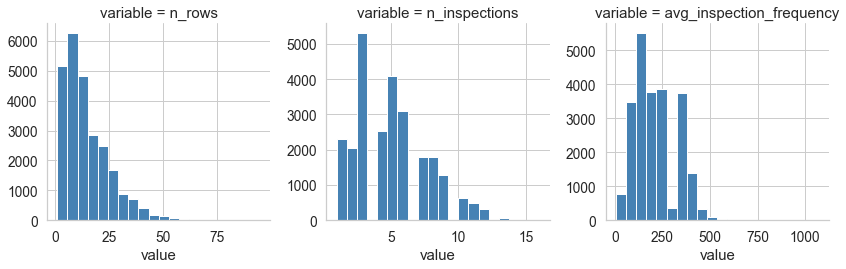

In [19]:
business_summary = core_inspections.groupby('CAMIS').aggregate(
    n_rows=('CAMIS', 'count'),
    n_inspections=('INSPECTION DATE', 'nunique'),
    avg_inspection_frequency=('INSPECTION DATE', lambda x: np.mean(np.diff(x.unique())).astype('timedelta64[D]'))
)
business_summary['avg_inspection_frequency'] = business_summary['avg_inspection_frequency'].dt.days
display(business_summary.info())

g = sns.FacetGrid(
    business_summary.melt(), col='variable',
    sharex=False, sharey=False, height=4
)
g.map(plt.hist, 'value', color='steelblue', bins=20)
plt.show()

### Summary of initial inspection failures

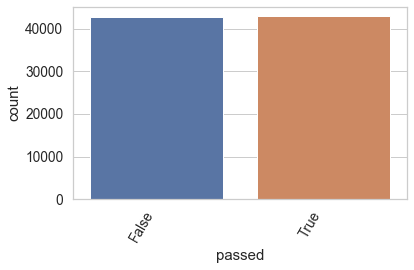

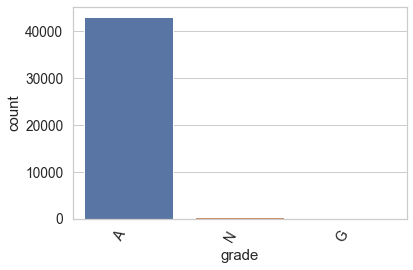

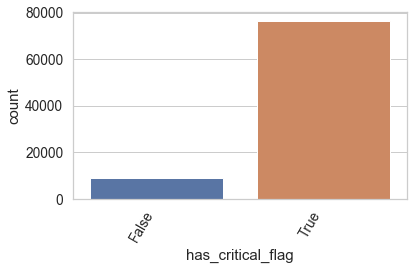

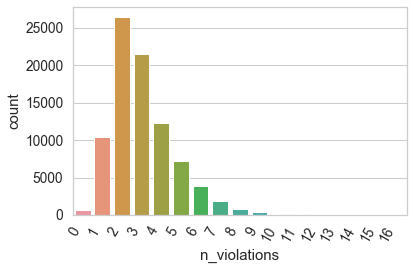

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85642 entries, 0 to 85641
Data columns (total 172 columns):
 #   Column                                                                    Non-Null Count  Dtype         
---  ------                                                                    --------------  -----         
 0   CAMIS                                                                     85642 non-null  int64         
 1   BORO                                                                      85642 non-null  category      
 2   INSPECTION DATE                                                           85642 non-null  datetime64[ns]
 3   inspection_month                                                          85642 non-null  category      
 4   inspection_dayofweek                                                      85642 non-null  category      
 5   CUISINE DESCRIPTION                                                       85642 non-null  category      
 6   INSPE

None

In [20]:
passing_grades = ('A', )
nonpassing_grades = ('B', 'C', )
pending_grades = ('N', 'Z', 'P', )

# Since there are NaNs in both gradeable and ungradeable, I'm going to infer that GRADE of NaN means non-passing
core_inspections.loc[core_inspections['is_gradeable'], 'GRADE'].value_counts(dropna=False)
core_inspections.loc[~core_inspections['is_gradeable'], 'GRADE'].value_counts(dropna=False)

# When using categorical variables in a groupby, Pandas will by default plan to have NaN values for each empty
# group as well, and that led to an array allocation error here. Using observed=True fixed it.
initial_inspections = core_inspections.loc[core_inspections['is_initial_inspection'], ].groupby(
    ['CAMIS', 'BORO', 'INSPECTION DATE', 'inspection_month', 'inspection_dayofweek',
     'CUISINE DESCRIPTION', 'INSPECTION TYPE'], observed=True).aggregate(
    passed=('GRADE', lambda x: x.iloc[0] == 'A'),
    grade=('GRADE', 'first'),
    has_critical_flag=('CRITICAL FLAG', lambda x: np.any(x == 'Y')),
    n_violations=('VIOLATION CODE', lambda x: x.loc[~x.isna()].nunique()),
    violation_codes=('VIOLATION CODE', lambda x: x.loc[~x.isna()].to_list())
).reset_index()

for v in ['passed', 'grade', 'has_critical_flag', 'n_violations']:
    g = sns.countplot(data=initial_inspections, x=v)
    g.set_xticklabels(g.get_xticklabels(), rotation=60, horizontalalignment='right')
    plt.tight_layout()
    plt.show()

# Add one-hot encoding for each violation code, BORO, and CUISINE DESCRIPTION
initial_inspections['violation_codes']
mlb = MultiLabelBinarizer()
expanded_violation_codes = mlb.fit_transform(initial_inspections['violation_codes'])
initial_inspections_violation_code_vars = 'violation_' + mlb.classes_
expanded_violation_codes = pd.DataFrame(expanded_violation_codes, columns=initial_inspections_violation_code_vars)
initial_inspections = pd.concat([initial_inspections, expanded_violation_codes], axis=1)

ohe = OneHotEncoder(sparse=False)
boro_encoding = ohe.fit_transform(initial_inspections['BORO'].to_numpy().reshape(-1, 1))
initial_inspections_boro_vars = 'BORO_' + ohe.categories_[0]
boro_encoding = pd.DataFrame(boro_encoding, columns=initial_inspections_boro_vars)
initial_inspections = pd.concat([initial_inspections, boro_encoding], axis=1)

ohe = OneHotEncoder(sparse=False)
cuisine_encoding = ohe.fit_transform(initial_inspections['CUISINE DESCRIPTION'].to_numpy().reshape(-1, 1))
initial_inspections_cuisine_vars = 'cuisine_' + ohe.categories_[0]
cuisine_encoding = pd.DataFrame(cuisine_encoding, columns=initial_inspections_cuisine_vars)
initial_inspections = pd.concat([initial_inspections, cuisine_encoding], axis=1)

display(initial_inspections.info(max_cols=500))

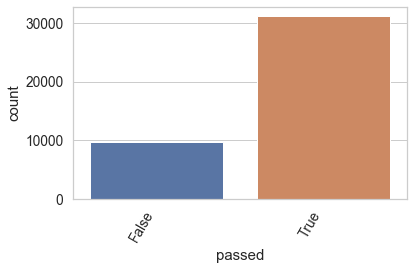

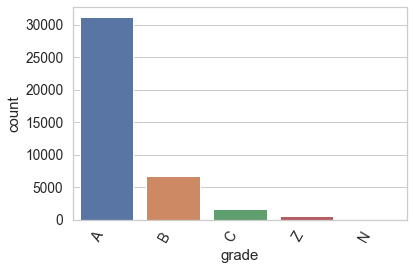

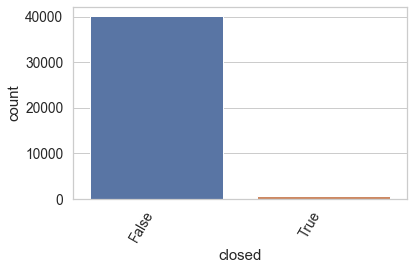

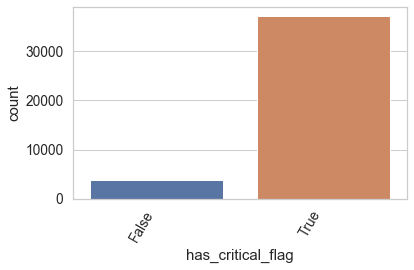

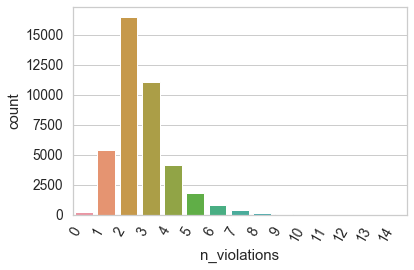

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40844 entries, 0 to 40843
Data columns (total 165 columns):
 #   Column                                                                    Non-Null Count  Dtype         
---  ------                                                                    --------------  -----         
 0   CAMIS                                                                     40844 non-null  int64         
 1   BORO                                                                      40844 non-null  category      
 2   INSPECTION DATE                                                           40844 non-null  datetime64[ns]
 3   inspection_month                                                          40844 non-null  category      
 4   inspection_dayofweek                                                      40844 non-null  category      
 5   CUISINE DESCRIPTION                                                       40844 non-null  category      
 6   INSPE

None

In [21]:
closed_actions = (
    'Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.',
    'Establishment re-closed by DOHMH',
)

reinspections = core_inspections.loc[core_inspections['is_reinspection'], ].groupby(
    ['CAMIS', 'BORO', 'INSPECTION DATE', 'inspection_month', 'inspection_dayofweek',
     'CUISINE DESCRIPTION', 'INSPECTION TYPE'], observed=True).aggregate(
    passed=('GRADE', lambda x: x.iloc[0] == 'A'),
    grade=('GRADE', 'first'),
    closed=('ACTION', lambda x: x.isin(closed_actions).any()),
    has_critical_flag=('CRITICAL FLAG', lambda x: np.any(x == 'Y')),
    n_violations=('VIOLATION CODE', lambda x: x.loc[~x.isna()].nunique()),
    violation_codes=('VIOLATION CODE', lambda x: x.loc[~x.isna()].to_list())
).reset_index()

# Put some plotting in here
for v in ['passed', 'grade', 'closed', 'has_critical_flag', 'n_violations']:
    g = sns.countplot(data=reinspections, x=v)
    g.set_xticklabels(g.get_xticklabels(), rotation=60, horizontalalignment='right')
    plt.tight_layout()
    plt.show()

reinspections['violation_codes']
mlb = MultiLabelBinarizer()
expanded_violation_codes = mlb.fit_transform(reinspections['violation_codes'])
expanded_violation_codes = pd.DataFrame(expanded_violation_codes, columns='violation_' + mlb.classes_)
reinspections = pd.concat([reinspections, expanded_violation_codes], axis=1)

ohe = OneHotEncoder(sparse=False)
boro_encoding = ohe.fit_transform(reinspections['BORO'].to_numpy().reshape(-1, 1))
reinspections_boro_vars = 'BORO_' + ohe.categories_[0]
boro_encoding = pd.DataFrame(boro_encoding, columns=reinspections_boro_vars)
reinspections = pd.concat([reinspections, boro_encoding], axis=1)

ohe = OneHotEncoder(sparse=False)
cuisine_encoding = ohe.fit_transform(reinspections['CUISINE DESCRIPTION'].to_numpy().reshape(-1, 1))
reinspections_cuisine_vars = 'cuisine_' + ohe.categories_[0]
cuisine_encoding = pd.DataFrame(cuisine_encoding, columns=reinspections_cuisine_vars)
reinspections = pd.concat([reinspections, cuisine_encoding], axis=1)

display(reinspections.info(max_cols=500))

## Find important features for classification of failed initial inspections using RandomForest

### Prepare data for random forest

Are there low-variance features that should be removed?

violation_17A1                                                              1.167651e-05
violation_19A3                                                              1.167651e-05
violation_17A3                                                              1.167651e-05
violation_04I                                                               1.167651e-05
violation_19A1                                                              1.167651e-05
violation_02J                                                               1.167651e-05
violation_04G                                                               2.335276e-05
cuisine_Basque                                                              2.335276e-05
violation_02E                                                               4.670442e-05
violation_03F                                                               4.670442e-05
cuisine_Chilean                                                             5.837984e-05
violation_03G        

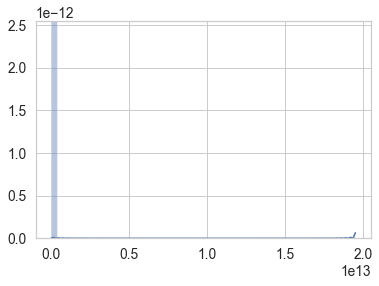

In [22]:
initial_inspections_variances = initial_inspections.var(axis=0)
with pd.option_context('display.max_rows', 200):
    display(initial_inspections_variances.sort_values())

g = sns.distplot(initial_inspections_variances, rug=False)
plt.show()

I'm not sure how meaningful variance is for categorical variables

### Just try running random forest to get it working

In [23]:
id_vars = ['CAMIS', 'INSPECTION DATE', 'INSPECTION TYPE', 'violation_codes', 'BORO', 'CUISINE DESCRIPTION']
label_vars = ['passed', 'grade']
feature_vars = list(set(initial_inspections.columns) - set(id_vars) - set(label_vars))
feature_vars.sort()

X = initial_inspections[feature_vars].to_numpy()
y = initial_inspections[label_vars[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=48)

forest = RandomForestClassifier(n_estimators=20, class_weight='balanced', oob_score=True, random_state=48)
forest.fit(X_train, y_train)
forest.predict(X_test)
forest.score(X_test, y_test)
print(forest.feature_importances_)
print(forest.oob_score_)
# g = sns.barplot(x=forest.feature_importances_, y=feature_vars)
# plt.show()

/Users/leslie/virtualenv/insight-data-challenges/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/leslie/virtualenv/insight-data-challenges/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:527: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


[5.83018776e-03 8.55978358e-03 8.66332571e-03 8.83052246e-03
 3.19069248e-03 1.30303325e-04 5.03214044e-04 7.63758295e-03
 1.92861801e-04 2.36439890e-03 1.33947259e-04 1.04947097e-03
 3.15821736e-03 6.75306845e-04 3.73160134e-04 3.29874392e-06
 8.07308015e-04 2.24319673e-04 4.46057384e-03 2.79506686e-05
 2.89663572e-05 3.04517647e-03 2.52192717e-03 9.26638788e-06
 5.96487337e-03 1.30787378e-04 4.77455558e-04 3.33678694e-04
 1.17578611e-04 1.40638082e-04 3.11045841e-05 1.79742769e-03
 2.43995578e-03 7.20006963e-04 2.02294142e-04 1.45290369e-04
 8.34166135e-05 1.83139623e-04 1.70189823e-03 2.15967266e-05
 2.79644648e-04 1.24043144e-03 1.95122469e-03 4.85334369e-04
 1.36480323e-04 1.49181422e-04 1.58636018e-03 2.01089822e-03
 4.76467948e-05 7.74984109e-05 1.22263500e-03 4.03256535e-03
 3.54698560e-03 1.89718277e-03 1.81606916e-03 1.55817989e-03
 3.76636951e-03 1.96002676e-03 3.74128210e-03 1.41792280e-03
 2.33397001e-04 9.02139290e-05 5.73526358e-05 6.93134498e-04
 2.98115155e-04 1.814802

This model looks fine, just based on accuracy (89%). Now to do cross-validation...

### Cross validation

In [24]:
chosen_metrics = ['accuracy', 'balanced_accuracy', 'f1', 'f1_weighted', 'recall', 'roc_auc']
forest = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=48)
cv_results = cross_validate(forest, X, y,
                            cv=StratifiedKFold(n_splits=5),
                            return_train_score=False,
                            scoring=chosen_metrics
                            )
cv_means = {k: np.mean(v) for k, v in cv_results.items()}
display(cv_means)

# n_estimators_grid = np.concatenate((np.arange(25, 175, 25), np.arange(200, 600, 100)))
# n_estimators_grid = np.arange(25, 175, 25)
# n_estimators_search = GridSearchCV(
#     estimator=RandomForestClassifier(random_state=48),
#     param_grid={'n_estimators': n_estimators_grid},
#     scoring=chosen_metrics,
#     n_jobs=3,
#     cv=StratifiedKFold(n_splits=5),
#     refit=False
# )
# n_estimators_search.fit(X, y)

{'fit_time': 6.609631967544556,
 'score_time': 0.5792642116546631,
 'test_accuracy': 0.8906610950850224,
 'test_balanced_accuracy': 0.8905647929055241,
 'test_f1': 0.8947524236178337,
 'test_f1_weighted': 0.8905035173880528,
 'test_recall': 0.9270042519270362,
 'test_roc_auc': 0.9414816146026108}

### Fit the final model

<ipython-input-25-d0d143467b23>:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


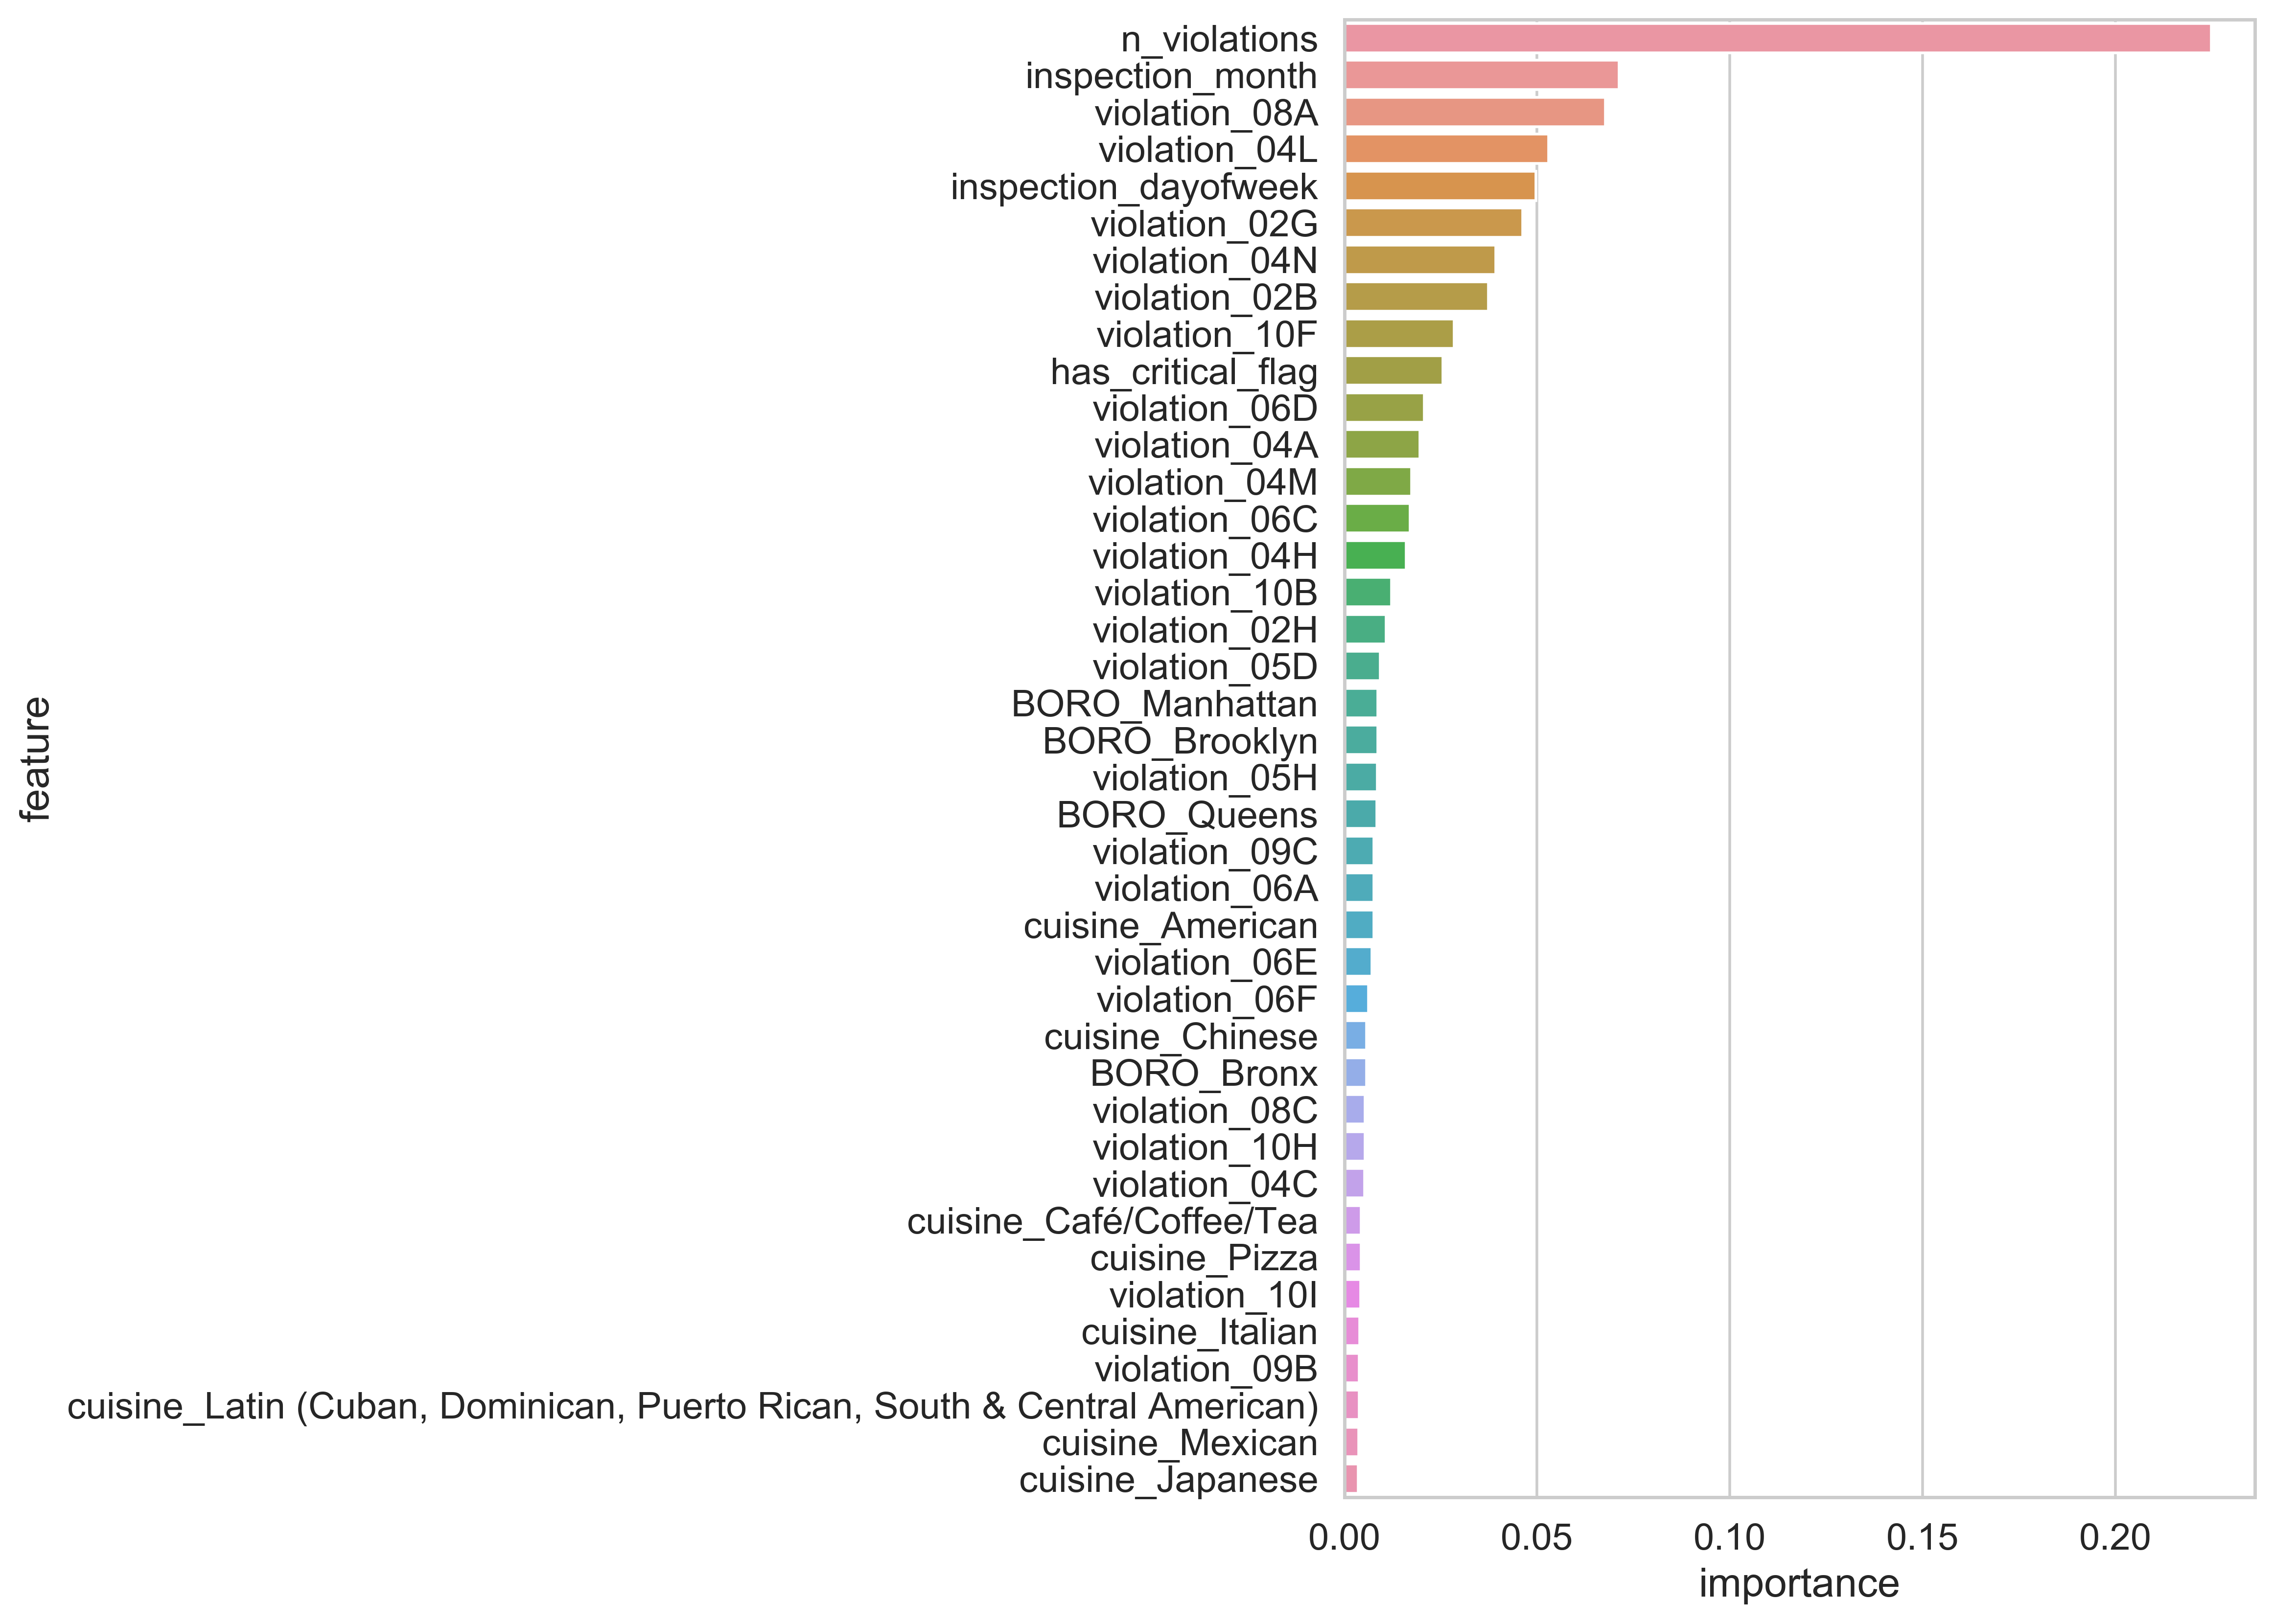

<Figure size 5120x3840 with 0 Axes>

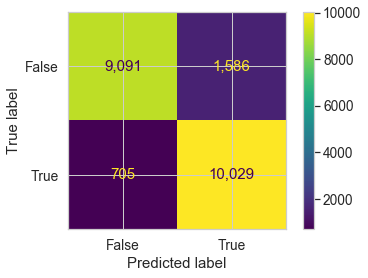

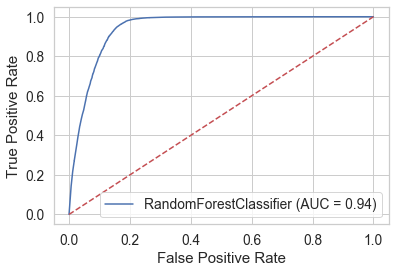

In [25]:
final_forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=48)
final_forest.fit(X_train, y_train)
final_predictions = final_forest.predict(X_test)
final_forest.feature_importances_

final_feature_importances = pd.DataFrame({'feature': feature_vars, 'importance': final_forest.feature_importances_})
final_feature_importances = final_feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(6, 10), dpi=400)
g = sns.barplot(x='importance', y='feature', data=final_feature_importances.head(40))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12.8, 9.6), dpi=400)
plot_confusion_matrix(final_forest, X_test, y_test, values_format=',.0f')
plt.show()

plot_roc_curve(final_forest, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k-', color='r', label='Chance', linestyle='--')
plt.show()

### Interpret the feature contributions

In [26]:
prediction, bias, contributions = ti.predict(final_forest, X_train[1, ].reshape(1, -1))
print("Prediction"), prediction
print("Bias (trainset prior)"), bias
print("Feature contributions:")
for c, feature in zip(contributions[0], feature_vars):
    print(feature, c)

Prediction
Bias (trainset prior)
Feature contributions:
BORO_Bronx [ 0.00068721 -0.00068721]
BORO_Brooklyn [-0.00387949  0.00387949]
BORO_Manhattan [-0.0078122  0.0078122]
BORO_Queens [ 0.00028115 -0.00028115]
BORO_Staten Island [ 0.00048569 -0.00048569]
cuisine_Afghan [0. 0.]
cuisine_African [-0.00018392  0.00018392]
cuisine_American [ 0.00501505 -0.00501505]
cuisine_Armenian [0. 0.]
cuisine_Asian [ 0.00017984 -0.00017984]
cuisine_Australian [-7.03818653e-06  7.03818653e-06]
cuisine_Bagels/Pretzels [-0.00045781  0.00045781]
cuisine_Bakery [ 0.00036544 -0.00036544]
cuisine_Bangladeshi [-0.00024228  0.00024228]
cuisine_Barbecue [ 1.58639227e-06 -1.58639227e-06]
cuisine_Basque [0. 0.]
cuisine_Bottled beverages, including water, sodas, juices, etc. [ 2.04916152e-05 -2.04916152e-05]
cuisine_Brazilian [-4.6362409e-06  4.6362409e-06]
cuisine_Café/Coffee/Tea [ 0.00231363 -0.00231363]
cuisine_Cajun [0. 0.]
cuisine_Californian [-6.02039056e-06  6.02039056e-06]
cuisine_Caribbean [-0.00046299  0.

I don't really find this very helpful. I would need to do this for every sample in the dataset to get something informative.
Go back to logistic regression so you can actually explain it!

## Find important features for classification of failed initial inspections using logistic regression

### Fit an initial logistic regression model

In [27]:
logreg = LogisticRegression(random_state=48, max_iter=1000, solver='saga')
logreg.fit(X_train, y_train)
logreg.predict(X_test)
print(logreg.score(X_test, y_test))

0.8812759796366354


### Cross validation of a basic logistic regression model

In [28]:
logreg = LogisticRegression(random_state=48, max_iter=1000, solver='saga')
cv_results = cross_validate(logreg, X, y,
                            cv=StratifiedKFold(n_splits=5),
                            return_train_score=False,
                            scoring=chosen_metrics
                            )
cv_means = {k: np.mean(v) for k, v in cv_results.items()}
display(cv_means)

{'fit_time': 45.836694431304934,
 'score_time': 0.18809151649475098,
 'test_accuracy': 0.8809812885375198,
 'test_balanced_accuracy': 0.8808422077621667,
 'test_f1': 0.8871914257209023,
 'test_f1_weighted': 0.8806309499435768,
 'test_recall': 0.9334558132894509,
 'test_roc_auc': 0.9336891096248463}

### Grid search to tune over regularization hyperparameters

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
13     130.638354     10.870846         0.121087        0.044780       4   
12     240.856813     16.643211         0.085895        0.002854       4   
15     171.972710     10.131188         0.084894        0.004413      10   
11      79.046243      6.915678         0.082315        0.002359       2   
14     277.103482     20.047711         0.086802        0.003914      10   
10     204.691519     24.759273         0.087433        0.004908       2   
8      112.459928     14.927161         0.088630        0.005871       1   
9       52.890059      3.603534         0.096252        0.015330       1   
7       35.193018      2.938707         0.096188        0.024846     0.5   
6       80.327483     12.535752         0.087452        0.003063     0.5   
5       14.542078      0.303146         0.088136        0.006330     0.1   
4       27.160078      3.423496         0.089615        0.007320     0.1   
3        4.060479      0.500668         0.088803        0.006115    0.01   
2        4.903152      0.317755         0.102013        0.010445    0.01   
1        2.221213      0.165567         0.106059        0.015170   0.001   
0        2.604341      0.163589         0.104438        0.042964   0.001   

   param_penalty                         params  split0_test_score  \
13            l2    {'C': 4.0, 'penalty': 'l2'}           0.937853   
12            l1    {'C': 4.0, 'penalty': 'l1'}           0.937872   
15            l2   {'C': 10.0, 'penalty': 'l2'}           0.937866   
11            l2    {'C': 2.0, 'penalty': 'l2'}           0.937821   
14            l1   {'C': 10.0, 'penalty': 'l1'}           0.937877   
10            l1    {'C': 2.0, 'penalty': 'l1'}           0.937855   
8             l1    {'C': 1.0, 'penalty': 'l1'}           0.937800   
9             l2    {'C': 1.0, 'penalty': 'l2'}           0.937749   
7             l2    {'C': 0.5, 'penalty': 'l2'}           0.937601   
6             l1    {'C': 0.5, 'penalty': 'l1'}           0.937643   
5             l2    {'C': 0.1, 'penalty': 'l2'}           0.936636   
4             l1    {'C': 0.1, 'penalty': 'l1'}           0.936515   
3             l2   {'C': 0.01, 'penalty': 'l2'}           0.931508   
2             l1   {'C': 0.01, 'penalty': 'l1'}           0.929001   
1             l2  {'C': 0.001, 'penalty': 'l2'}           0.916663   
0             l1  {'C': 0.001, 'penalty': 'l1'}           0.895304   

    split1_test_score  split2_test_score  split3_test_score  \
13           0.934894           0.929771           0.933417   
12           0.934882           0.929744           0.933393   
15           0.934848           0.929750           0.933400   
11           0.934936           0.929782           0.933425   
14           0.934839           0.929737           0.933391   
10           0.934914           0.929746           0.933395   
8            0.934940           0.929738           0.933417   
9            0.934976           0.929797           0.933429   
7            0.934978           0.929770           0.933402   
6            0.934958           0.929680           0.933376   
5            0.934456           0.929161           0.932663   
4            0.934543           0.928795           0.932798   
3            0.929853           0.923907           0.925499   
2            0.927317           0.920434           0.922145   
1            0.914642           0.906736           0.906609   
0            0.892179           0.880567           0.881270   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
13           0.932714         0.933730        0.002652                1   
12           0.932737         0.933726        0.002663                2   
15           0.932749         0.933722        0.002656                3   
11           0.932639         0.933721        0.002648                4   
14           0.932758         0.933720        0.002662                5  

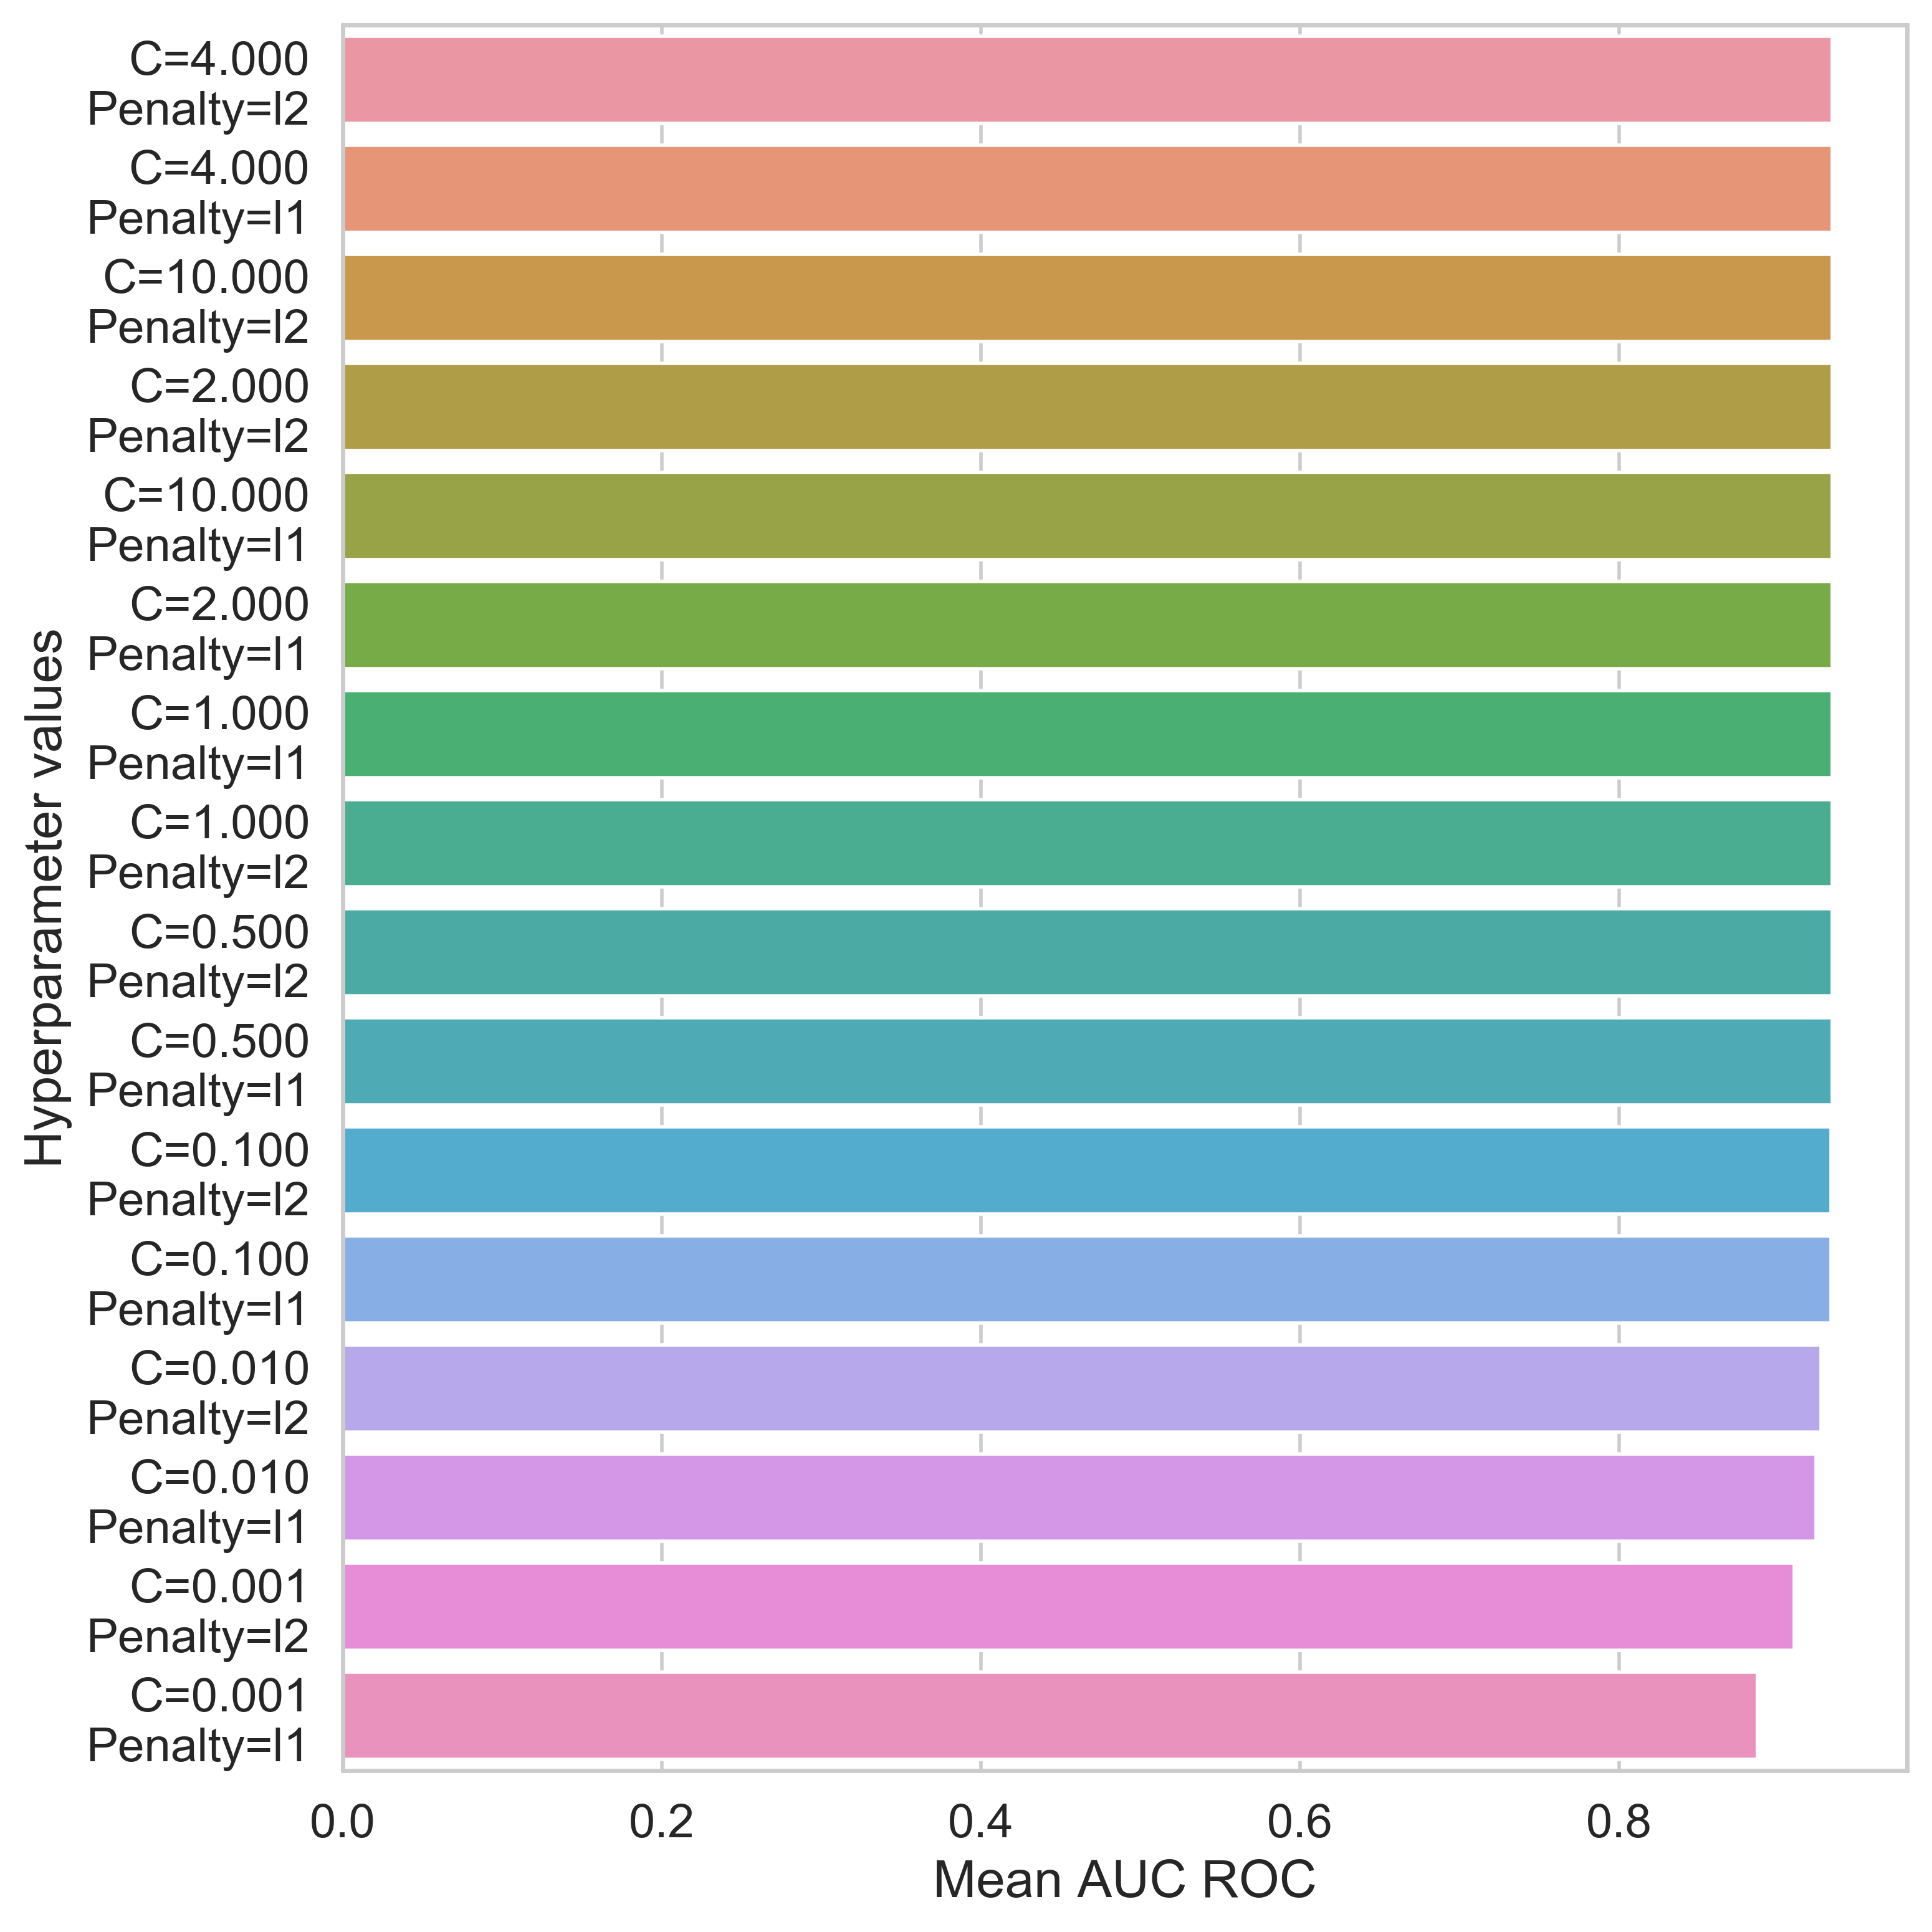

<Figure size 5120x3840 with 0 Axes>

<Figure size 5120x3840 with 0 Axes>

In [29]:
param_grid = {
    # C = inverse of regularization strength; positive float; smaller C = stronger regularization
    'C': (10.0, 4.0, 2.0, 1.0, 0.5, 0.1, 0.01, 0.001),  # Similar to defaults for LogisticRegressionCV
    'penalty': ['l1', 'l2']  # Regularization penalty type; L1 = Lasso, L2 = Ridge
    # L1 = penalized by absolute value of coefficient magnitude
    # L2 = penalized by squared magnitude of coefficient
}

logreg_gridsearch_outfile = os.path.join(os.path.expanduser(output_dir), 'logreg_gridsearch_results.pickle')

# The higher the value of C, the longer the fit takes and the higher the max_iter needed.
# Use saga solver because it is faster for large data and supports both L1 and L2 regularization
if not os.path.exists(logreg_gridsearch_outfile):
    classifier_grid_search = GridSearchCV(
        estimator=LogisticRegression(solver='saga', random_state=48, max_iter=5000),
        param_grid=param_grid,
        cv=5, scoring='roc_auc', verbose=2, n_jobs=3
    )
    grid_search_models = classifier_grid_search.fit(X, y)
    with open(logreg_gridsearch_outfile, 'wb') as f:
        pickle.dump(grid_search_models, f, pickle.HIGHEST_PROTOCOL)
else:
    with open(logreg_gridsearch_outfile, 'rb') as f:
        grid_search_models = pickle.load(f)

grid_search_results = pd.DataFrame(grid_search_models.cv_results_)
grid_search_results['params_string'] = grid_search_results['params'].apply(
    lambda x: 'C={:.3f}\nPenalty={}'.format(x['C'], x['penalty']))
grid_search_results = grid_search_results.sort_values(by='rank_test_score', ascending=True)
display(grid_search_results)

plt.figure(figsize=(8, 8), dpi=400)
g = sns.barplot(x='mean_test_score', y='params_string', data=grid_search_results)
g.set(xlabel='Mean AUC ROC', ylabel='Hyperparameter values')
plt.tight_layout()
plt.show()
plt.figure(figsize=(12.8, 9.6), dpi=400)

L1 and L2 regularization are bascially both good. And any C higher than 0.1 is good.
I chose C = 0.1 and penalty = l2 because they're fastest of the ones with good AUC ROC.

### Fit the final logistic regression model

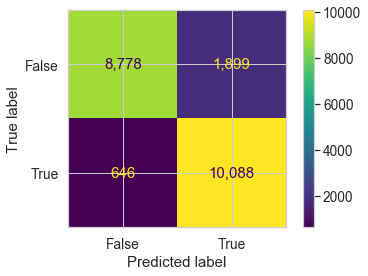

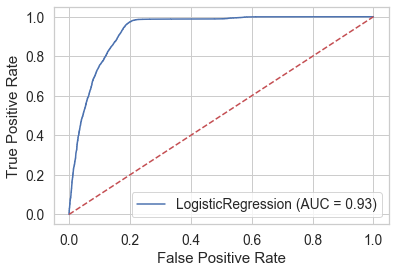

In [30]:
final_C = 0.1
final_penalty = 'l2'
final_logreg = LogisticRegression(random_state=48, max_iter=5000, C=final_C, penalty=final_penalty, solver='saga')
final_logreg.fit(X_train, y_train)
final_logreg_predictions = final_logreg.predict(X_test)

plot_confusion_matrix(final_logreg, X_test, y_test, values_format=',.0f')
plt.show()

plot_roc_curve(final_logreg, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k-', color='r', label='Chance', linestyle='--')
plt.show()

### Gather coefficients & odds ratios

coef_ gives the coefficients contributing to classes_[1], which is "True" for passing the initial inspection.

So coefficients quantify contribution to probability of passing initial inspection.

Odds ratios greater than 1.0 indicating a higher probability of passing the initial inspection and ORs less than 1.0 indicate a lower probability of passing the initial inspection.

In [31]:
final_coefficients = pd.DataFrame({'feature': feature_vars, 'coefficient': final_logreg.coef_[0]})
# coef_ gives the coefficients contributing to classes_[1], which is passed="True"
final_coefficients['magnitude'] = final_coefficients['coefficient'].abs()
final_coefficients['direction'] = np.sign(final_coefficients['coefficient'])
final_coefficients['direction'] = final_coefficients['direction'].replace({-1.0: 'negative', 1.0: 'positive', 0: 'NA'})
final_coefficients = final_coefficients.sort_values('magnitude', ascending=False)
final_coefficients['odds_ratio'] = np.exp(final_coefficients['coefficient'])
# The odds ratio is the ratio of the odds of passing inspection to the odds of failing inspection. For a given feature, it is the OR when other features are held constant.

with pd.option_context('display.max_rows', 200):
    display(final_coefficients.sort_values('odds_ratio', ascending=False))

# g = sns.barplot(x='magnitude', y='feature', hue='direction', data=final_coefficients.head(40))
# g.set(xlabel='Coefficient magnitude', ylabel='Feature')
# plt.tight_layout()
# plt.show()

feature  coefficient  \
163                                      violation_22G     2.556921   
142                                      violation_08A     2.171691   
147                                      violation_09C     2.137372   
153                                      violation_10F     2.093325   
89                                   has_critical_flag     1.985416   
152                                      violation_10E     1.754944   
156                                      violation_10I     1.743388   
151                                      violation_10D     1.741737   
149                                      violation_10B     1.679691   
155                                      violation_10H     1.607446   
150                                      violation_10C     1.574857   
148                                      violation_10A     1.571497   
146                                      violation_09B     1.551063   
143                                      violation_08B     1.387294   
157                                      violation_10J     1.352866   
162                                      violation_22F     1.295181   
144                                      violation_08C     1.274366   
145                                      violation_09A     1.175359   
63                                       cuisine_Other     0.647470   
46             cuisine_Ice Cream, Gelato, Yogurt, Ices     0.605456   
44                                     cuisine_Hotdogs     0.553503   
32                                      cuisine_Donuts     0.450474   
154                                      violation_10G     0.404492   
134                                      violation_06C     0.400099   
79                          cuisine_Soups & Sandwiches     0.349127   
135                                      violation_06D     0.294019   
42                                  cuisine_Hamburgers     0.281832   
27                                 cuisine_Continental     0.273667   
18                             cuisine_Café/Coffee/Tea     0.264316   
54              cuisine_Juice, Smoothies, Fruit Salads     0.257232   
36                                   cuisine_Ethiopian     0.248021   
82                                       cuisine_Steak     0.244850   
73                                  cuisine_Sandwiches     0.241068   
12                                      cuisine_Bakery     0.235758   
11                             cuisine_Bagels/Pretzels     0.228483   
5                                       cuisine_Afghan     0.227349   
50                                       cuisine_Irish     0.227183   
101                                      violation_02I     0.224385   
137                                      violation_06F     0.215406   
45                            cuisine_Hotdogs/Pretzels     0.212824   
16   cuisine_Bottled beverages, including water, so...     0.209334   
72                                      cuisine_Salads     0.206039   
30                                       cuisine_Czech     0.195299   
62                          cuisine_Nuts/Confectionary     0.195280   
74              cuisine_Sandwiches/Salads/Mixed Buffet     0.172098   
133                                      violation_06B     0.171037   
124                                      violation_04O     0.169345   
87                                  cuisine_Vegetarian     0.150598   
40                                      cuisine_German     0.138983   
136                                      violation_06E     0.123351   
7                                     cuisine_American     0.112380   
38                                      cuisine_French     0.107451   
83                                       cuisine_Tapas     0.105754   
19                                       cuisine_Cajun     0.092364   
70                                  cuisine_Portuguese     0.084660   
4                                   BORO_Staten Island     0.083102   


### Investigate model results

#### What are odds ratios for the various violation codes?

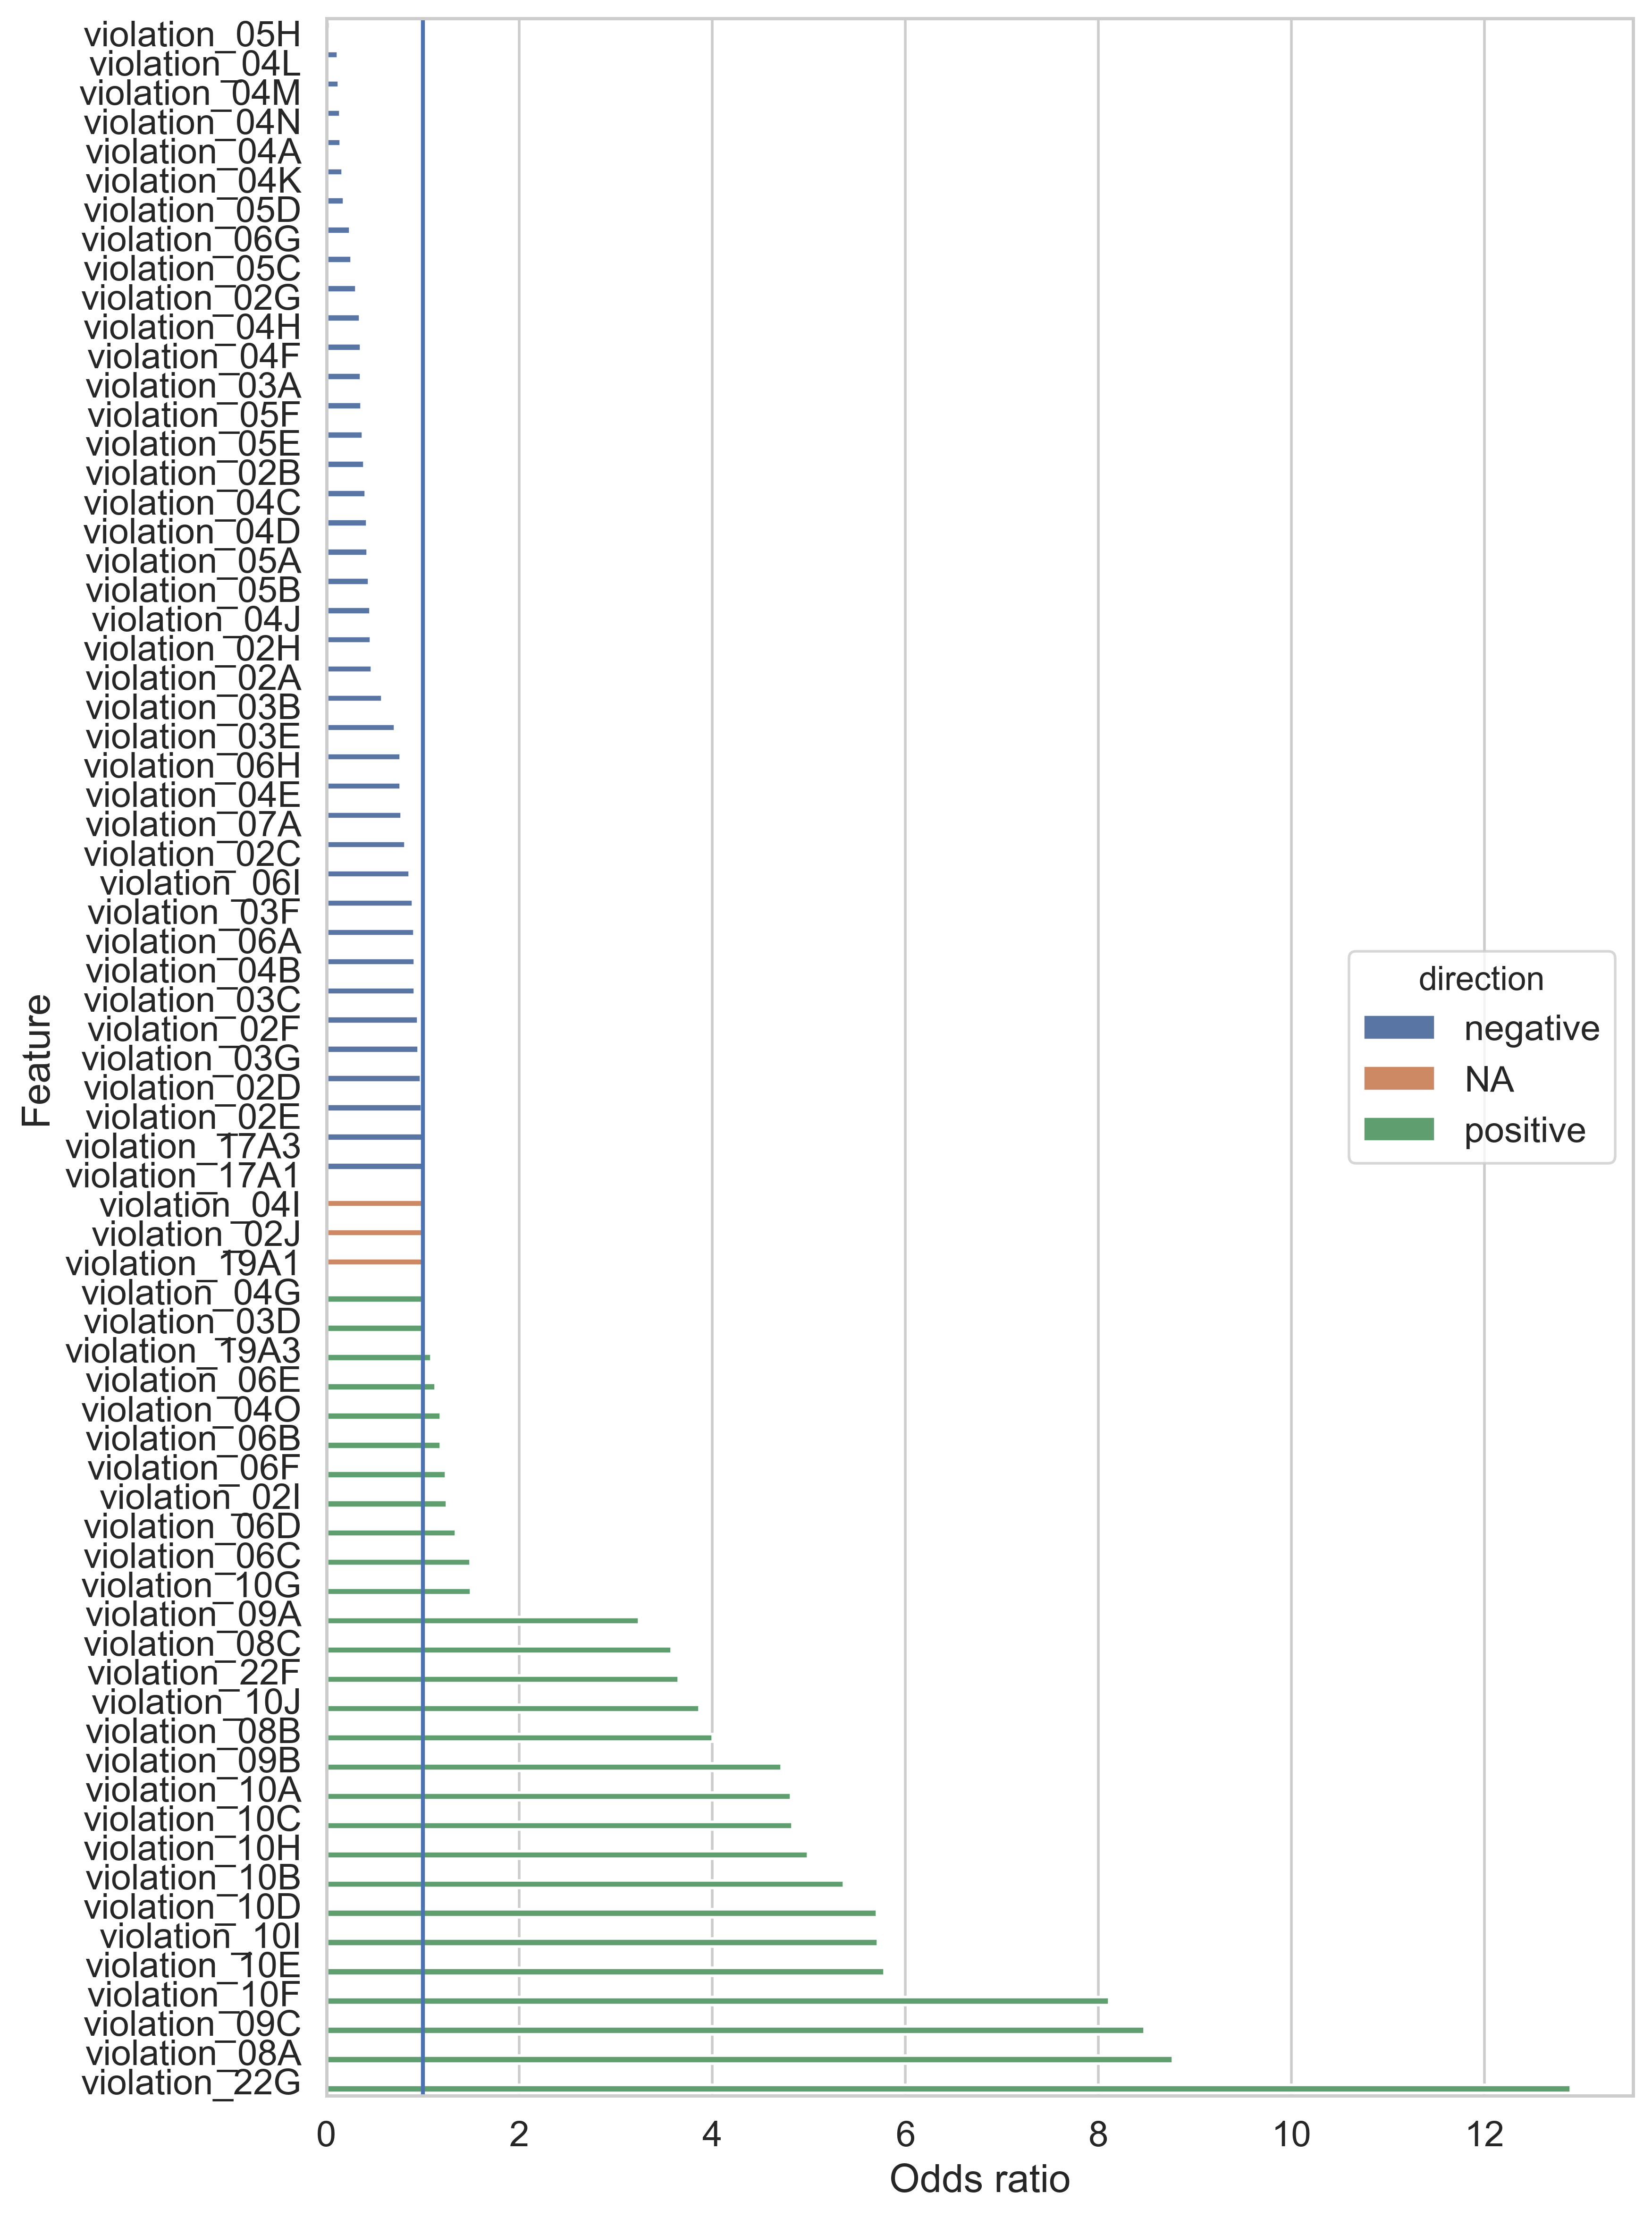

HIGHEST ODDS RATIO VIOLATION CODES - higher odds of passing initial inspection


VIOLATION DESCRIPTION
VIOLATION CODE                                                                                                                                                       
08A                                Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.
09C                                                                                                                     Food contact surface not properly maintained.
10B             Plumbing not properly installed or maintained; anti-siphonage or backflow prevention device not provided where required; equipment or floor not pr...
10C                                            Lighting inadequate; permanent lighting not provided in food preparation areas, ware washing areas, and storage rooms.
10D             Mechanical or natural ventilation system not provided, improperly installed, in disrepair and/or fails to prevent excessive build-up of grease, he...
10E                                                                                       Accurate thermometer not provided in refrigerated or hot holding equipment.
10F             Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or no...
10H                                                                                              Proper sanitization not provided for utensil ware washing operation.
10I                                                                                 Single service item reused, improperly stored, dispensed; not used when required.
22G                                                                                                                                                               NaN

LOWEST ODDS RATIO VIOLATION CODES - lower odds of passing initial inspection


VIOLATION DESCRIPTION
VIOLATION CODE                                                                                                                                                       
02G                                  Cold food item held above 41º F (smoked fish and reduced oxygen packaged foods above 38 ºF) except during necessary preparation.
04A                                                                                            Food Protection Certificate not held by supervisor of food operations.
04K                                                                                   Evidence of rats or live rats present in facility's food and/or non-food areas.
04L                                                                                   Evidence of mice or live mice present in facility's food and/or non-food areas.
04M                                                                                                    Live roaches present in facility's food and/or non-food areas.
04N             Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility’s food and/or non-food areas. Filth flies include house flies, littl...
05C                                                                               Food contact surface improperly constructed or located. Unacceptable material used.
05D             Hand washing facility not provided in or near food preparation area and toilet room. Hot and cold running water at adequate pressure to enable cle...
05H                                                                                    No facilities available to wash, rinse and sanitize utensils and/or equipment.
06G                                                                                        HACCP plan not approved or approved HACCP plan not maintained on premises.

In [32]:
plt.figure(figsize=(9, 12), dpi=400)
g = sns.barplot(x='odds_ratio', y='feature', hue='direction',
                data=final_coefficients[final_coefficients['feature'].isin(
                    initial_inspections_violation_code_vars)].sort_values('odds_ratio', ascending=True))
g.axvline(1.0)
g.set(xlabel='Odds ratio', ylabel='Feature')
plt.tight_layout()
plt.show()

top_violation_codes = final_coefficients.loc[final_coefficients['feature'].isin(
    initial_inspections_violation_code_vars),
].sort_values('odds_ratio', ascending=False).head(10)['feature'].str.replace('violation_', '')

bottom_violation_codes = final_coefficients.loc[final_coefficients['feature'].isin(
    initial_inspections_violation_code_vars),
].sort_values('odds_ratio', ascending=True).head(10)['feature'].str.replace('violation_', '')

with pd.option_context('display.max_colwidth', 150):
    print('HIGHEST ODDS RATIO VIOLATION CODES - higher odds of passing initial inspection')
    display(violation_descriptions.loc[violation_descriptions.index.isin(top_violation_codes), ])
    print('LOWEST ODDS RATIO VIOLATION CODES - lower odds of passing initial inspection')
    display(violation_descriptions.loc[violation_descriptions.index.isin(bottom_violation_codes), ])

Investigating the violation code 22G with a missing description:

https://rules.cityofnewyork.us/tags/sanitary-inspection

"In the list of unscored violations, a new violation code 22G containing a penalty for violations of Administrative Code §16-329 (c) which prohibits use of expanded polystyrene single service articles, is being added.   "
https://www1.nyc.gov/office-of-the-mayor/news/295-18/mayor-de-blasio-ban-single-use-styrofoam-products-new-york-city-will-be-effect
From a recent ban on styrofoam products!

What is an HACCP plan? 

"Hazard Analysis Critical Control Points (HACCP) is an internationally recognized method of identifying and managing food safety related risk and, when central to an active food safety program, can provide your customers, the public, and regulatory agencies assurance that a food safety program is well managed." (Source)[https://safefoodalliance.com/food-safety-resources/haccp-overview/]

#### What are odds ratios for the boroughs?

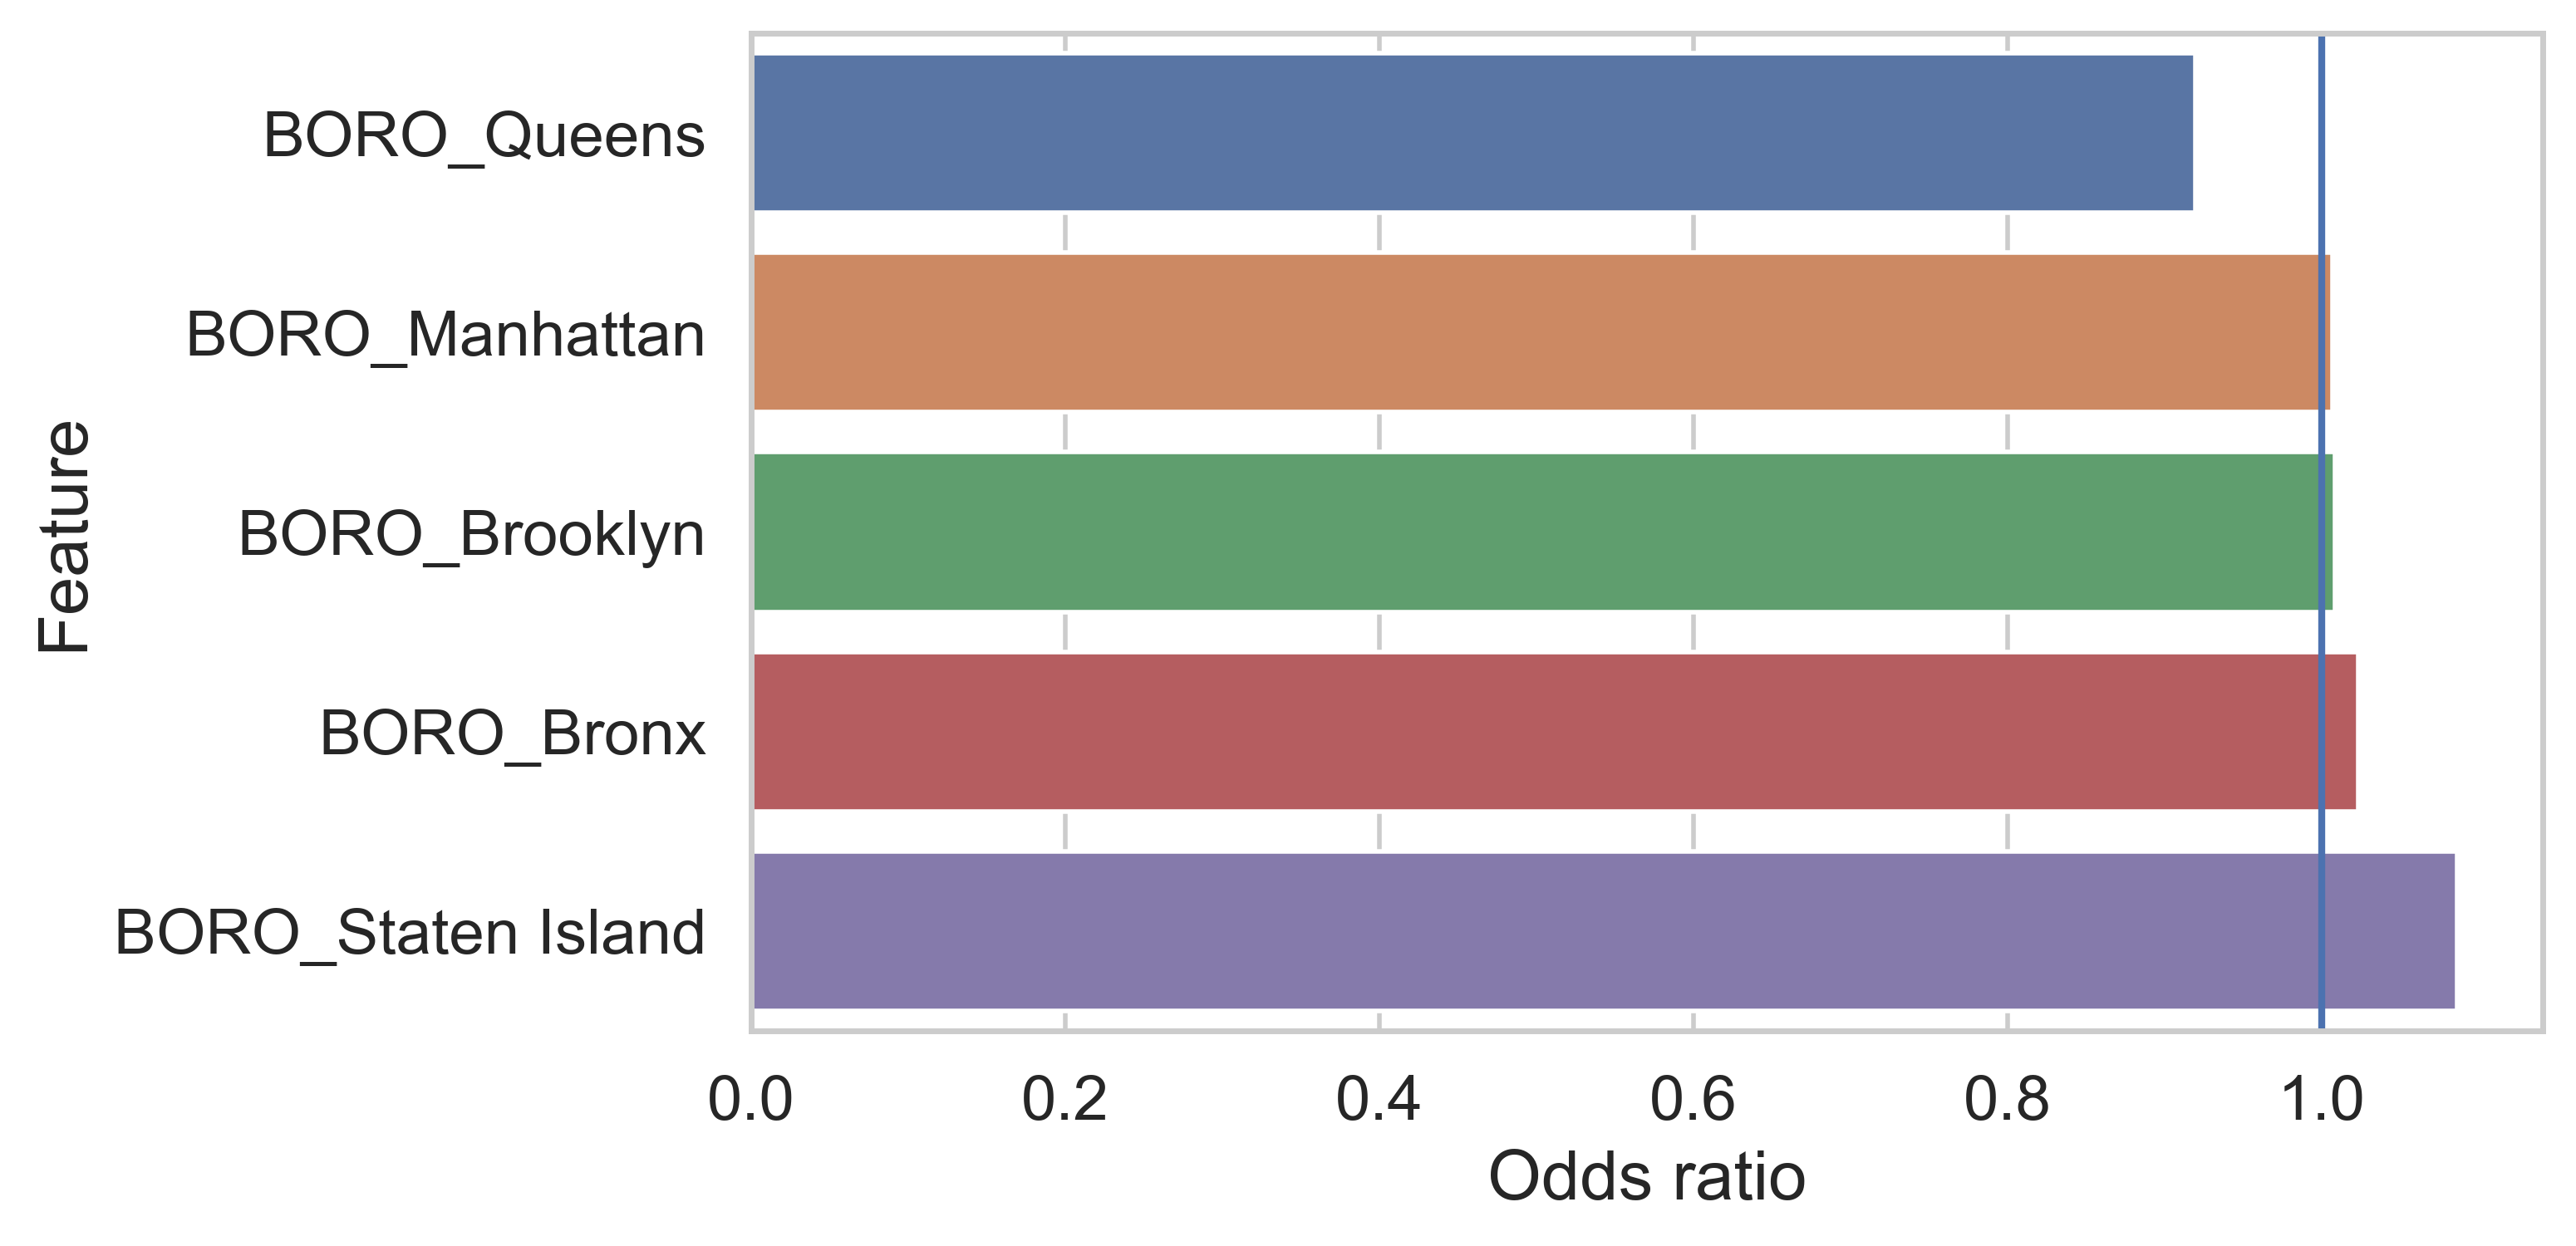

In [33]:
plt.figure(figsize=(8, 4), dpi=400)
g = sns.barplot(x='odds_ratio', y='feature',
                data=final_coefficients[final_coefficients['feature'].isin(
                    initial_inspections_boro_vars)].sort_values('odds_ratio', ascending=True))
g.set(xlabel='Odds ratio', ylabel='Feature')
g.axvline(1.0)
plt.tight_layout()
plt.show()

The boroughs are all pretty close to having the same odds of passing initial inspection, though Queens and Staten Island are perhaps a bit different. It's hard to say without p values for the coefficients, which I would need to use a different package or do bootstrapping for.

#### What are odds ratios for the various cuisines?

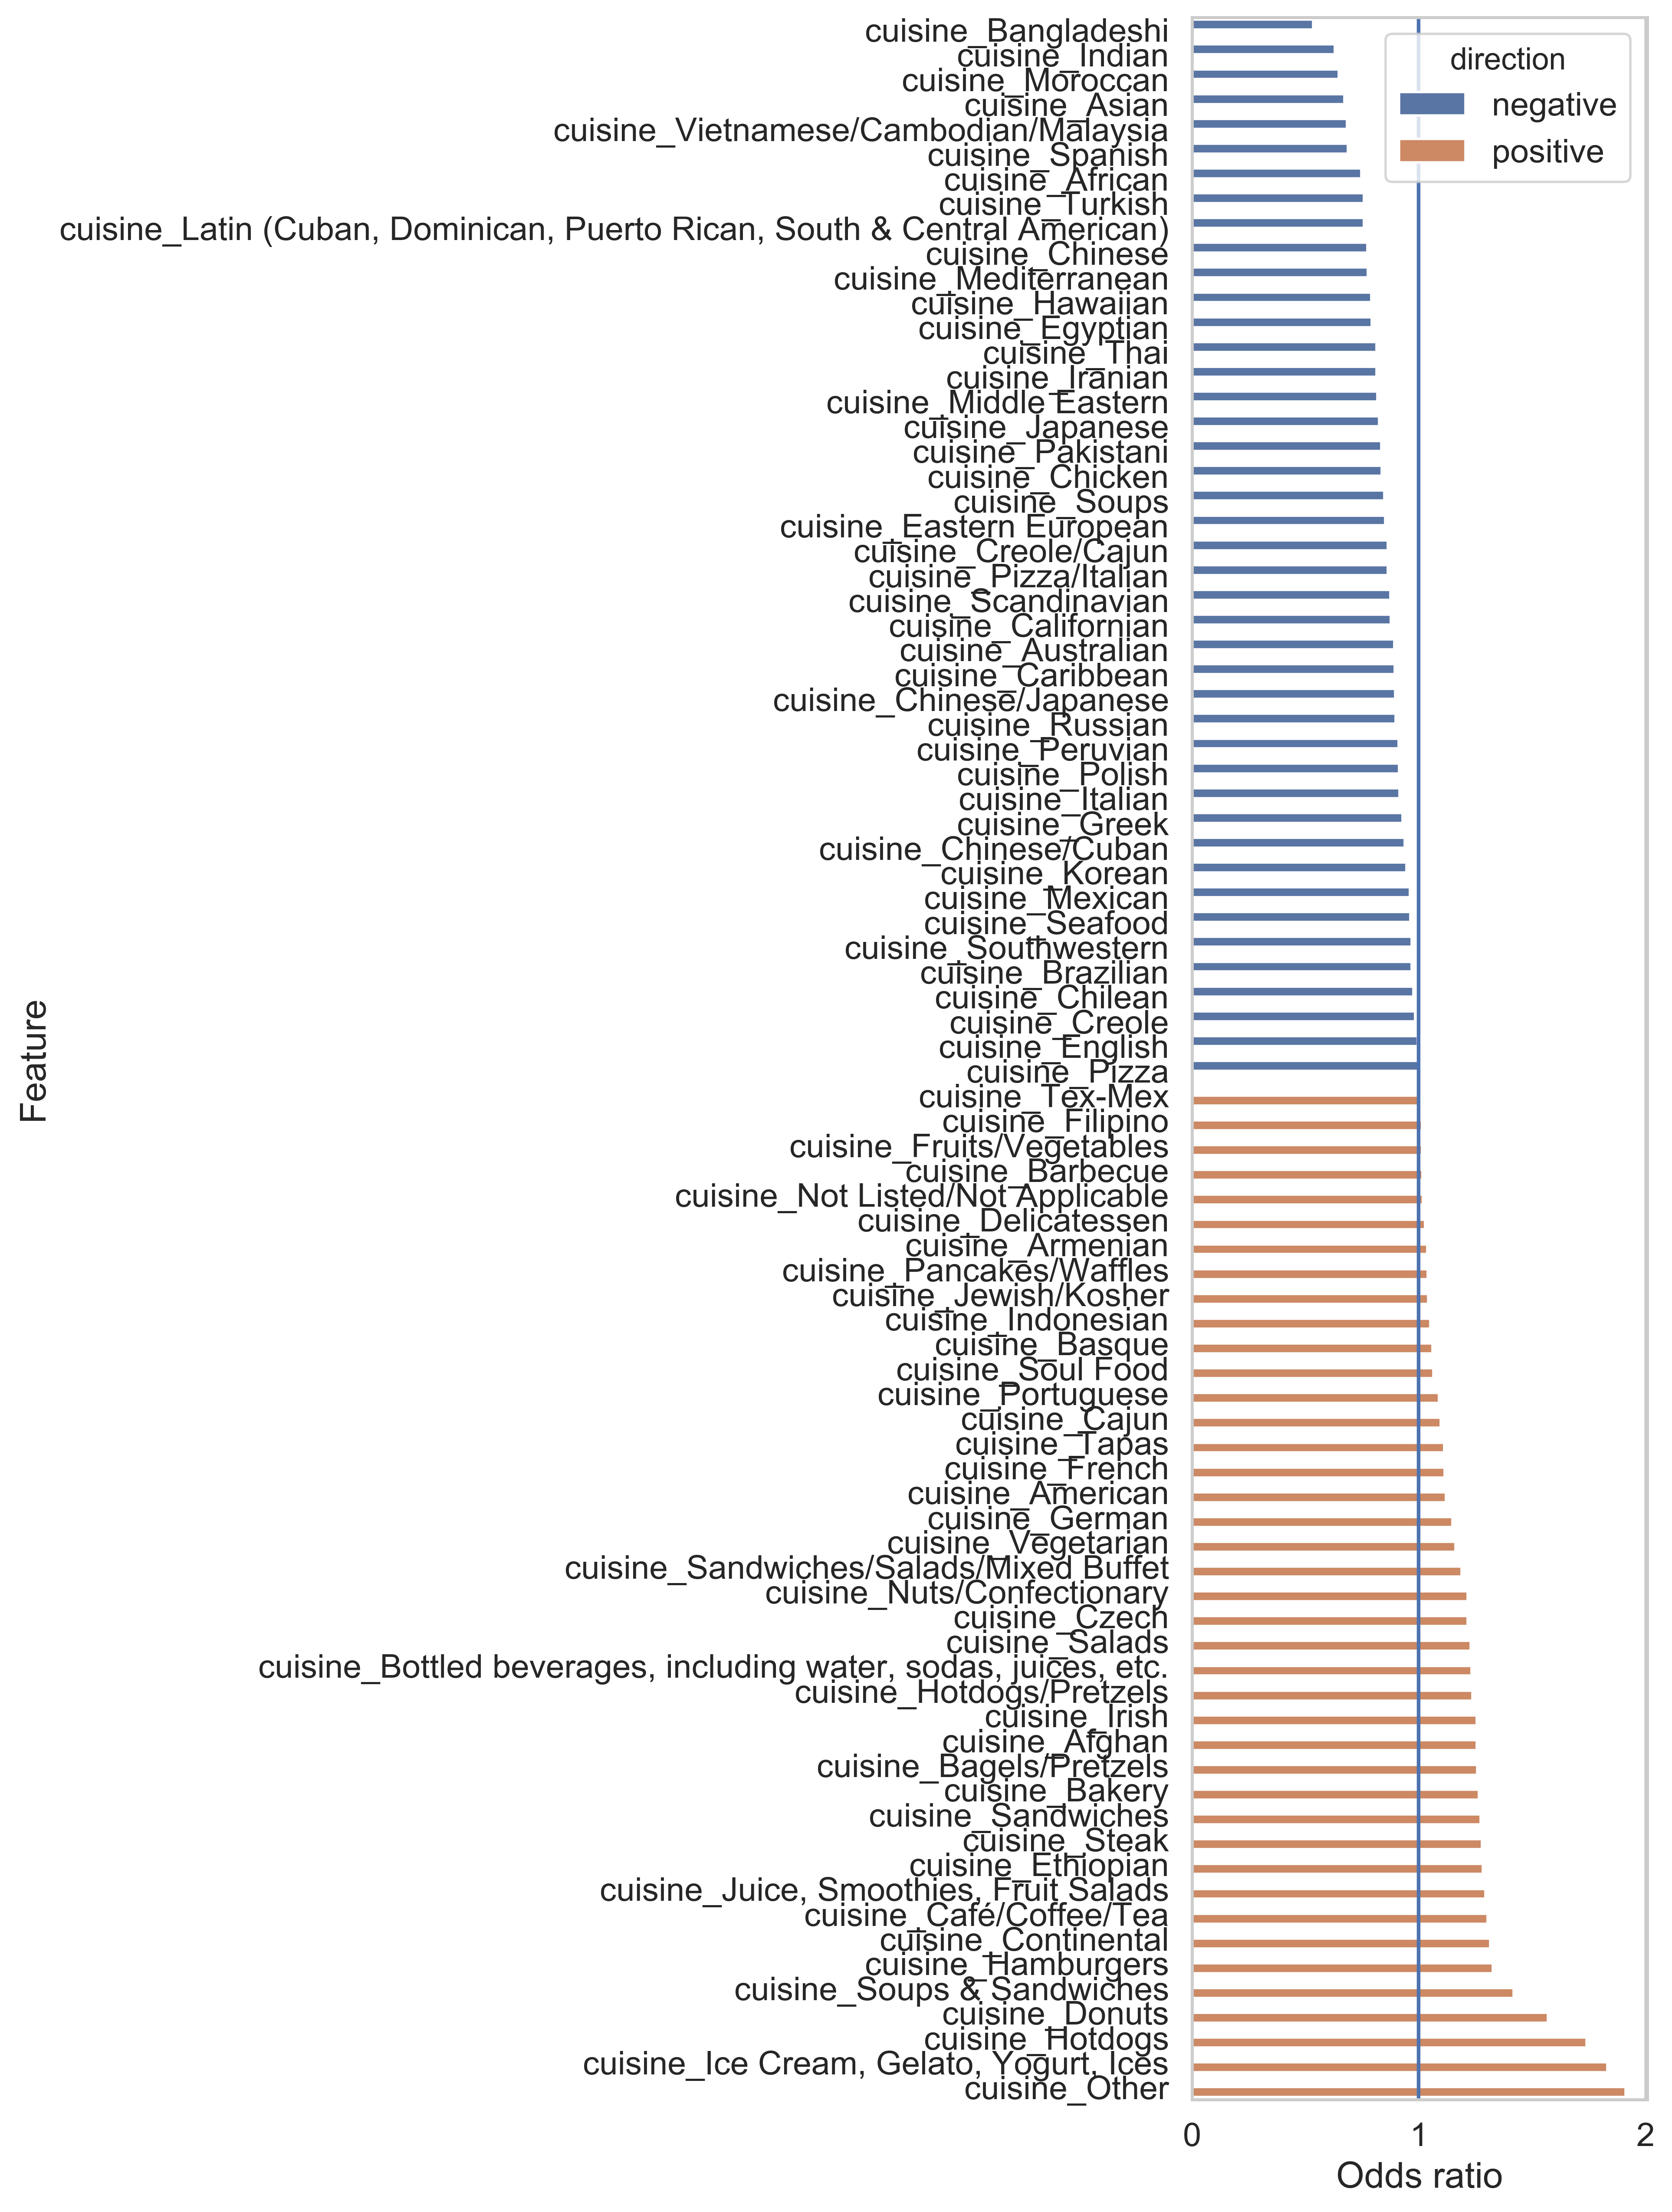

HIGHEST ODDS RATIO CUISINES


feature  coefficient  magnitude  \
63                                      cuisine_Other     0.647470   0.647470   
46            cuisine_Ice Cream, Gelato, Yogurt, Ices     0.605456   0.605456   
44                                    cuisine_Hotdogs     0.553503   0.553503   
32                                     cuisine_Donuts     0.450474   0.450474   
79                         cuisine_Soups & Sandwiches     0.349127   0.349127   
42                                 cuisine_Hamburgers     0.281832   0.281832   
27                                cuisine_Continental     0.273667   0.273667   
18                            cuisine_Café/Coffee/Tea     0.264316   0.264316   
54             cuisine_Juice, Smoothies, Fruit Salads     0.257232   0.257232   
36                                  cuisine_Ethiopian     0.248021   0.248021   
82                                      cuisine_Steak     0.244850   0.244850   
73                                 cuisine_Sandwiches     0.241068   0.241068   
12                                     cuisine_Bakery     0.235758   0.235758   
11                            cuisine_Bagels/Pretzels     0.228483   0.228483   
5                                      cuisine_Afghan     0.227349   0.227349   
50                                      cuisine_Irish     0.227183   0.227183   
45                           cuisine_Hotdogs/Pretzels     0.212824   0.212824   
16  cuisine_Bottled beverages, including water, so...     0.209334   0.209334   
72                                     cuisine_Salads     0.206039   0.206039   
30                                      cuisine_Czech     0.195299   0.195299   
62                         cuisine_Nuts/Confectionary     0.195280   0.195280   
74             cuisine_Sandwiches/Salads/Mixed Buffet     0.172098   0.172098   
87                                 cuisine_Vegetarian     0.150598   0.150598   
40                                     cuisine_German     0.138983   0.138983   
7                                    cuisine_American     0.112380   0.112380   
38                                     cuisine_French     0.107451   0.107451   
83                                      cuisine_Tapas     0.105754   0.105754   
19                                      cuisine_Cajun     0.092364   0.092364   
70                                 cuisine_Portuguese     0.084660   0.084660   
77                                  cuisine_Soul Food     0.061914   0.061914   
15                                     cuisine_Basque     0.058489   0.058489   
48                                 cuisine_Indonesian     0.049852   0.049852   
53                              cuisine_Jewish/Kosher     0.039852   0.039852   
65                           cuisine_Pancakes/Waffles     0.038564   0.038564   
8                                    cuisine_Armenian     0.037377   0.037377   
31                               cuisine_Delicatessen     0.027683   0.027683   
61                  cuisine_Not Listed/Not Applicable     0.018858   0.018858   
14                                   cuisine_Barbecue     0.016568   0.016568   
39                          cuisine_Fruits/Vegetables     0.015237   0.015237   
37                                   cuisine_Filipino     0.013647   0.013647   
84                                    cuisine_Tex-Mex     0.000323   0.000323   

   direction  odds_ratio  
63  positive    1.910702  
46  positive    1.832088  
44  positive    1.739336  
32  positive    1.569055  
79  positive    1.417829  
42  positive    1.325556  
27  positive    1.314777  
18  positive    1.302540  
54  positive    1.293346  
36  positive    1.281487  
82  positive    1.277430  
73  positive    1.272607  
12  positive    1.265868  
11  positive    1.256692  
5   positive    1.255267  
50  positive    1.255060  
45  positive    1.237167  
16  positive    1.232856  
72  positive    1.228801  
30  positive    1.215674  
62  positive    1.215651  
74  positive    1.187794  
87  positive    1.1625

LOWEST ODDS RATIO CUISINES


feature  coefficient  magnitude  \
13                                cuisine_Bangladeshi    -0.625785   0.625785   
47                                     cuisine_Indian    -0.462765   0.462765   
60                                   cuisine_Moroccan    -0.435422   0.435422   
9                                       cuisine_Asian    -0.397764   0.397764   
88              cuisine_Vietnamese/Cambodian/Malaysia    -0.381881   0.381881   
81                                    cuisine_Spanish    -0.376247   0.376247   
6                                     cuisine_African    -0.293220   0.293220   
86                                    cuisine_Turkish    -0.277291   0.277291   
56  cuisine_Latin (Cuban, Dominican, Puerto Rican,...    -0.276765   0.276765   
24                                    cuisine_Chinese    -0.257379   0.257379   
57                              cuisine_Mediterranean    -0.254592   0.254592   
43                                   cuisine_Hawaiian    -0.235926   0.235926   
34                                   cuisine_Egyptian    -0.232104   0.232104   
85                                       cuisine_Thai    -0.205207   0.205207   
49                                    cuisine_Iranian    -0.205178   0.205178   
59                             cuisine_Middle Eastern    -0.202597   0.202597   
52                                   cuisine_Japanese    -0.192875   0.192875   
64                                  cuisine_Pakistani    -0.181047   0.181047   
22                                    cuisine_Chicken    -0.177621   0.177621   
78                                      cuisine_Soups    -0.164943   0.164943   
33                           cuisine_Eastern European    -0.160678   0.160678   
29                               cuisine_Creole/Cajun    -0.147959   0.147959   
68                              cuisine_Pizza/Italian    -0.147136   0.147136   
75                               cuisine_Scandinavian    -0.133506   0.133506   
20                                cuisine_Californian    -0.130746   0.130746   
10                                 cuisine_Australian    -0.115010   0.115010   
21                                  cuisine_Caribbean    -0.113140   0.113140   
26                           cuisine_Chinese/Japanese    -0.109927   0.109927   
71                                    cuisine_Russian    -0.107606   0.107606   
66                                   cuisine_Peruvian    -0.093975   0.093975   
69                                     cuisine_Polish    -0.091327   0.091327   
51                                    cuisine_Italian    -0.088438   0.088438   
41                                      cuisine_Greek    -0.074131   0.074131   
25                              cuisine_Chinese/Cuban    -0.063148   0.063148   
55                                     cuisine_Korean    -0.056152   0.056152   
58                                    cuisine_Mexican    -0.040352   0.040352   
76                                    cuisine_Seafood    -0.038116   0.038116   
80                               cuisine_Southwestern    -0.032426   0.032426   
17                                  cuisine_Brazilian    -0.032270   0.032270   
23                                    cuisine_Chilean    -0.023546   0.023546   
28                                     cuisine_Creole    -0.015699   0.015699   
35                                    cuisine_English    -0.004349   0.004349   
67                                      cuisine_Pizza    -0.002631   0.002631   

   direction  odds_ratio  
13  negative    0.534842  
47  negative    0.629541  
60  negative    0.646991  
9   negative    0.671821  
88  negative    0.682576  
81  negative    0.686433  
6   negative    0.745858  
86  negative    0.757834  
56  negative    0.758232  
24  negative    0.773075  
57  negative    0.775233  
43  negative    0.789839  
34  negative    0.792864  
85  negative    0.814478  
49  negative    0.814502  
59  negative    0.816608  
52  negative    0.8245

In [34]:
plt.figure(figsize=(10, 13), dpi=400)
g = sns.barplot(x='odds_ratio', y='feature', hue='direction',
                data=final_coefficients[final_coefficients['feature'].isin(
                    initial_inspections_cuisine_vars)].sort_values('odds_ratio', ascending=True))
g.axvline(1.0)
g.set(xlabel='Odds ratio', ylabel='Feature')
plt.tight_layout()
plt.show()

top_cuisines = final_coefficients.loc[
    final_coefficients['feature'].isin(initial_inspections_cuisine_vars) & (final_coefficients['odds_ratio'] > 1.0),
].sort_values('odds_ratio', ascending=False)

bottom_cuisines = final_coefficients.loc[
    final_coefficients['feature'].isin(initial_inspections_cuisine_vars) & (final_coefficients['odds_ratio'] < 1.0),
].sort_values('odds_ratio', ascending=True)

with pd.option_context('display.max_rows', 100):
    print('HIGHEST ODDS RATIO CUISINES')
    display(top_cuisines)
    print('LOWEST ODDS RATIO CUISINES')
    display(bottom_cuisines)

Just by eye, it does appear that many of the "ethnic" food categories are in the lower OR range.
If cuisine type is the effect, then this could indicate a concerning bias in the inspections. If it is the cause, then it would just mean there are (potentially systemic) reasons for these particular cuisine types to be less likely to pass inspections.

All of the high OR cuisines make a lot of sense, like ice cream shops, donut shops, cafes, etc. where there is less food prep and less equipment and facilities to maintain.

#### What about the other features?

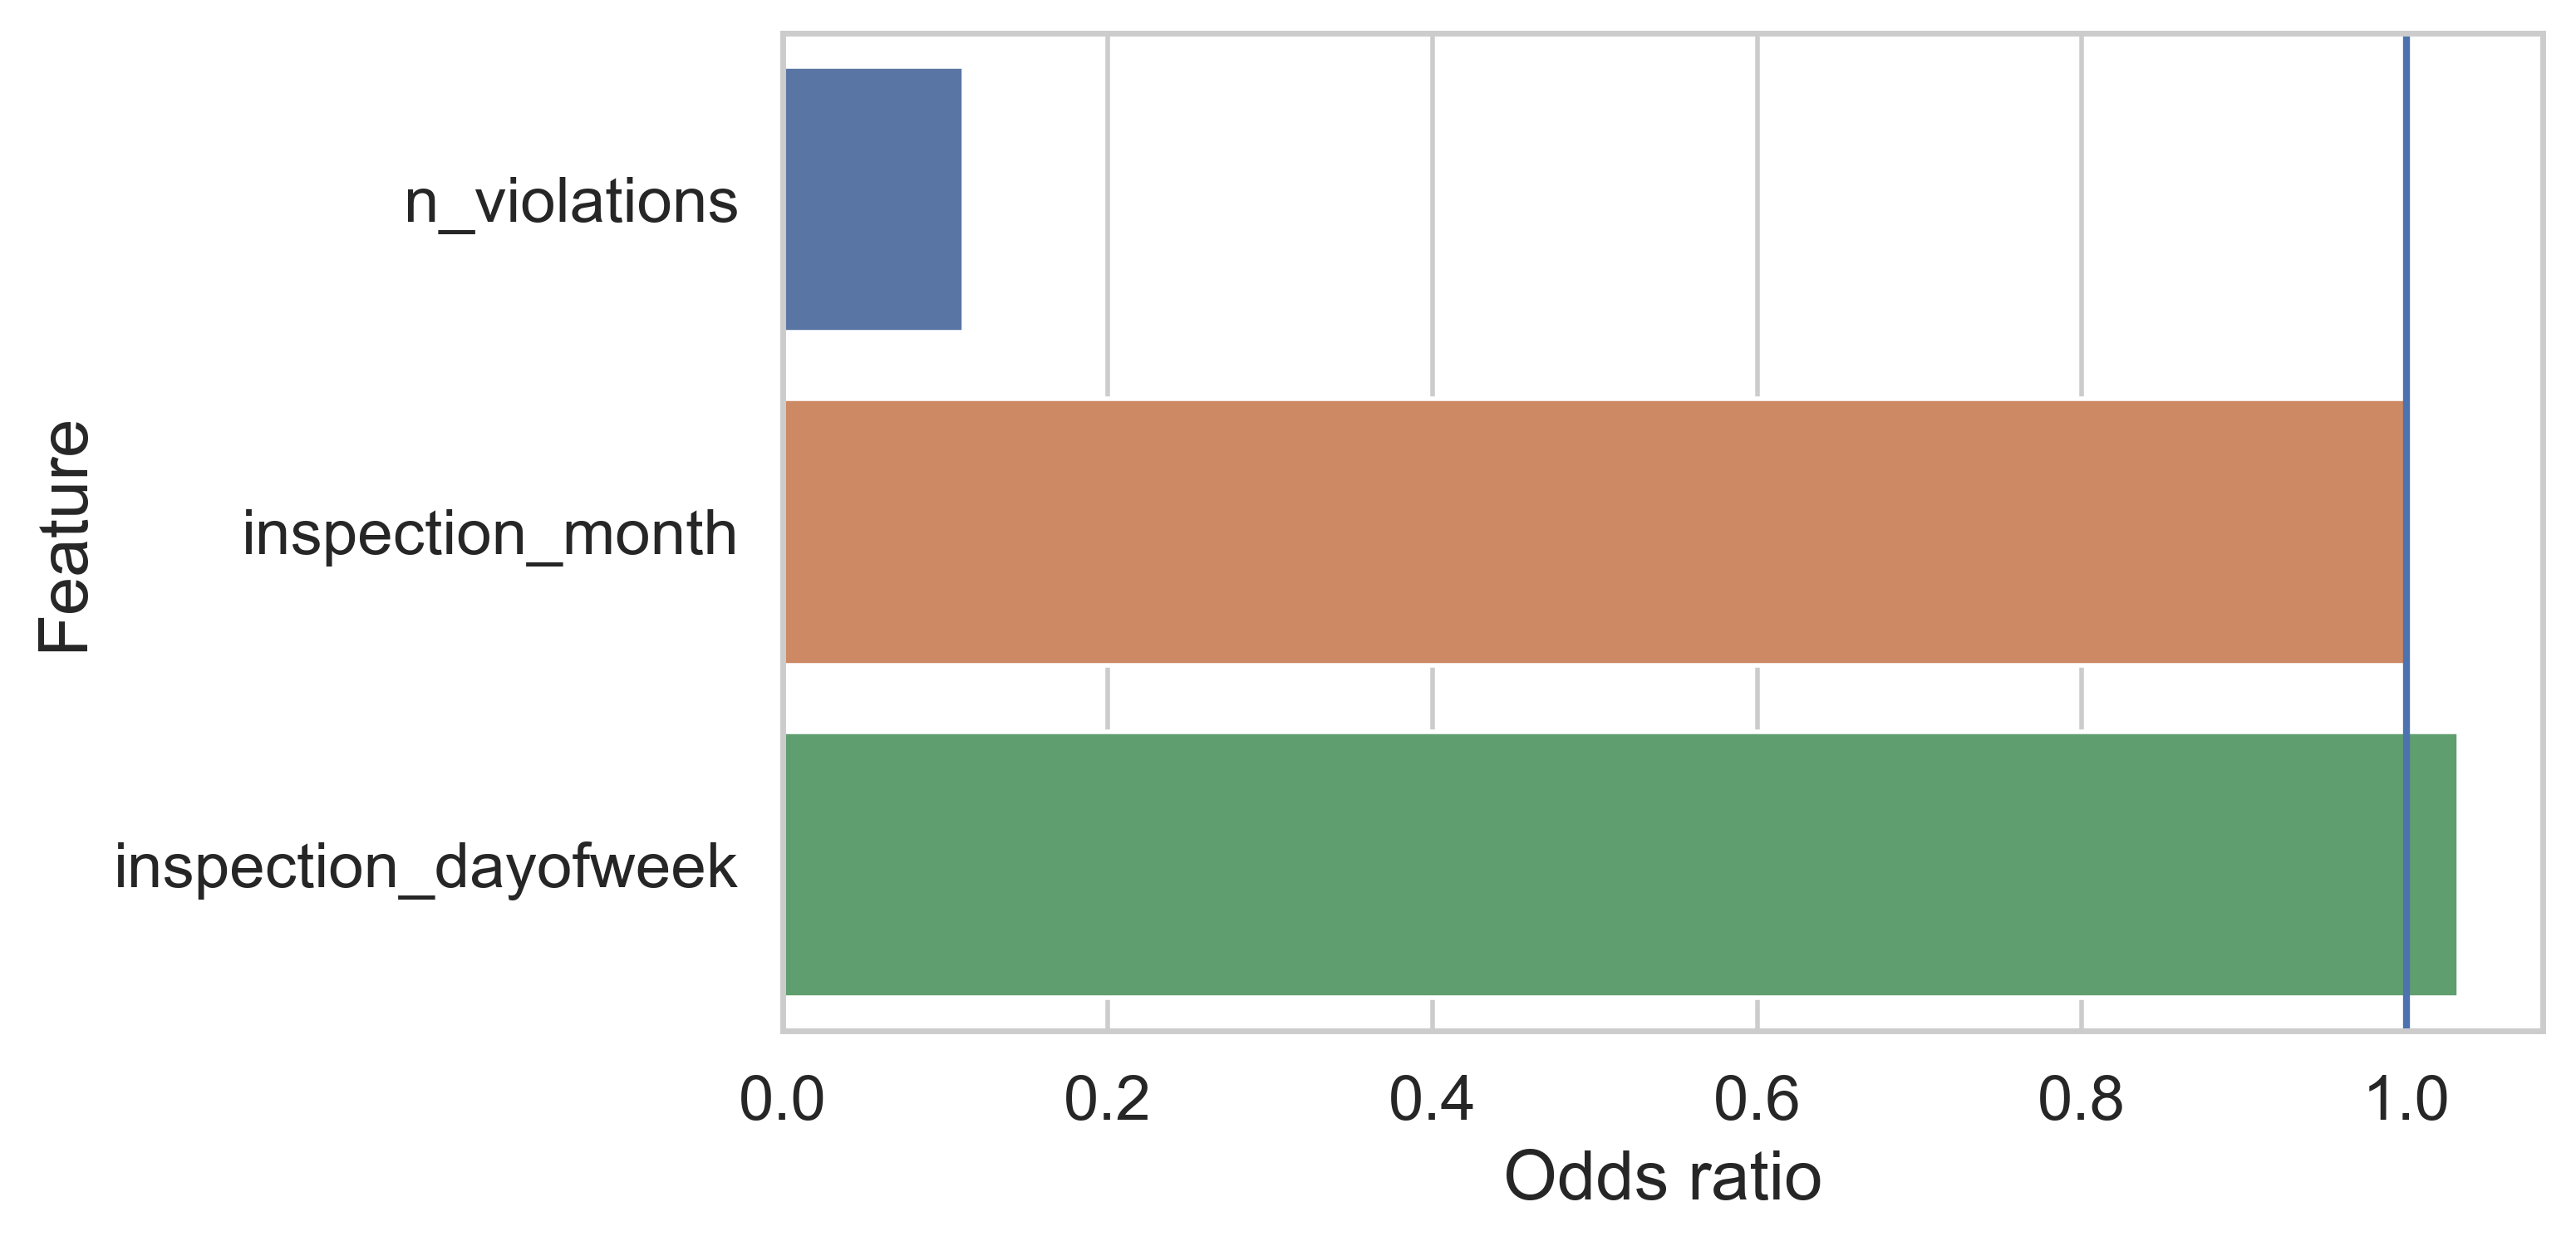

VIOLATION DESCRIPTION  \
0    Food Protection Certificate not held by superv...   
2    Food contact surface not properly washed, rins...   
4           Hot food item not held at or above 140º F.   
5    Food contact surface not properly washed, rins...   
6           Hot food item not held at or above 140º F.   
7    Raw, cooked or prepared food is adulterated, c...   
9    Food not protected from potential source of co...   
10   Food not protected from potential source of co...   
12   Wiping cloths soiled or not stored in sanitizi...   
14   Food contact surface not properly washed, rins...   
18   Food contact surface not properly washed, rins...   
20          Hot food item not held at or above 140º F.   
22   Food worker does not use proper utensil to eli...   
23   Sanitized equipment or utensil, including in-u...   
24          Hot food item not held at or above 140º F.   
25   Filth flies or food/refuse/sewage-associated (...   
26   Filth flies or food/refuse/sewage-associated (...   
29   Cold food item held above 41º F (smoked fish a...   
31   Evidence of mice or live mice present in facil...   
32   Filth flies or food/refuse/sewage-associated (...   
35   Cold food item held above 41º F (smoked fish a...   
36   Evidence of mice or live mice present in facil...   
39   Cold food item held above 41º F (smoked fish a...   
40   Toxic chemical improperly labeled, stored or u...   
41   Filth flies or food/refuse/sewage-associated (...   
42   Food worker does not use proper utensil to eli...   
51   Food contact surface not properly washed, rins...   
57   Personal cleanliness inadequate. Outer garment...   
60          Hot food item not held at or above 140º F.   
62   Raw, cooked or prepared food is adulterated, c...   
65   Personal cleanliness inadequate. Outer garment...   
66   Live roaches present in facility's food and/or...   
68   Live roaches present in facility's food and/or...   
69   Cold food item held above 41º F (smoked fish a...   
71   Food not protected from potential source of co...   
72   Raw, cooked or prepared food is adulterated, c...   
73          Hot food item not held at or above 140º F.   
74   Food worker does not use proper utensil to eli...   
75   Appropriately scaled metal stem-type thermomet...   
76   Sanitized equipment or utensil, including in-u...   
77   Raw, cooked or prepared food is adulterated, c...   
78   Food not protected from potential source of co...   
79   Personal cleanliness inadequate. Outer garment...   
81    Food not cooked to required minimum temperature.   
82   Evidence of mice or live mice present in facil...   
83   Personal cleanliness inadequate. Outer garment...   
87   Food contact surface not properly washed, rins...   
88          Hot food item not held at or above 140º F.   
90   Cold food item held above 41º F (smoked fish a...   
91   Cold food item held above 41º F (smoked fish a...   
93          Hot food item not held at or above 140º F.   
94   Evidence of mice or live mice present in facil...   
95   Food contact surface not properly washed, rins...   
98   Food Protection Certificate not held by superv...   
99   Evidence of mice or live mice present in facil...   
100         Hot food item not held at or above 140º F.   
101  Food not protected from potential source of co...   
103  Cold food item held above 41º F (smoked fish a...   
104  Food contact surface not properly washed, rins...   
107  Cold food item held above 41º F (smoked fish a...   
109  Cold food item held above 41º F (smoked fish a...   
111  Live roaches present in facility's food and/or...   
115  Food contact surface not properly washed, rins...   
117  Evidence of mice or live mice present in facil...   
118  Live roaches present in facility's food and/or...   
121  Hand washing facility not provided in or near ...   
122  Sanitized equipment or utensil, including in-u...   
123  Wiping cloths soiled or not stored in sanitizi...   
126  Food not protected from po

In [35]:
other_vars = (set(feature_vars) - set(initial_inspections_boro_vars) - set(('has_critical_flag', ))
              - set(initial_inspections_cuisine_vars) - set(initial_inspections_violation_code_vars))

plt.figure(figsize=(8, 4), dpi=400)
g = sns.barplot(x='odds_ratio', y='feature',
                data=final_coefficients[final_coefficients['feature'].isin(
                    other_vars)].sort_values('odds_ratio', ascending=True))
g.axvline(1.0)
g.set(xlabel='Odds ratio', ylabel='Feature')
plt.tight_layout()
plt.show()

inspections['CRITICAL FLAG'].value_counts(dropna=False)
with pd.option_context('display.max_rows', 100):
    display(inspections.loc[(inspections['CRITICAL FLAG'] == 'Y'), ['VIOLATION DESCRIPTION', 'ACTION']].head(100))

It looks like something is wrong with 'has_critical_flag' because way too many inspections have this. This is true of the original 'CRITICAL FLAG' variable as well, and the values don't match what's in the DD, so I'm concerned about it.
It's also concerning that `has_critical_flag` appears to be associated with higher odds of **passing** the initial inspection, by quite a bit (OR=7.3).

References:
- https://medium.com/@sam.weinger/looking-for-borough-bias-in-nyc-restaurant-inspection-results-e15640cd3f97
- https://www.foodsafetynews.com/2018/05/harvard-researchers-say-fixing-food-safety-inspectors-schedules-could-end-many-violations/

- https://www.researchgate.net/post/Im_trying_to_apply_random_forests_in_a_sparse_data_set_Unfortunately_there_is_more_than_40_error_in_my_result_Can_anyone_suggest_where_to_refine
- https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

- https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e
- https://blog.datadive.net/random-forest-interpretation-with-scikit-learn/
- https://github.com/andosa/treeinterpreter

- https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/
- https://stackoverflow.com/questions/39626401/how-to-get-odds-ratios-and-other-related-features-with-scikit-learn

In [36]:
# This code is used to run the .py script from beginning to end in the python interpreter
# with open('python/nyc-restaurant-inspections.py', 'r') as f:
#     exec(f.read())

# plt.close('all')